In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import h5py
import torchvision
import numpy as np
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchsummary import summary
from aux_functions import inverse_normalize,angle_to_2d,is_accurate, plot_metrics, draw_gaze360_arrow
from datasets import MPIIFaceGaze,Gaze360Dataset
from random import randint

In [3]:
from models import GazeEstimation_ResNet18, GazeEstimation_ResNet18Branch, GazeEstimation_MobileNet

# Task

- Predict gaze angle froma picture of the face of an individual.
- Dataset: MPIIFaceGaze. [Link here](https://www.mpi-inf.mpg.de/de/departments/computer-vision-and-machine-learning/research/gaze-based-human-computer-interaction/its-written-all-over-your-face-full-face-appearance-based-gaze-estimation).
    - Dataset consists in images of 15 individuals.
    - There are 3000 images per individual. Gaze labels: pitch angle (vertical movement) and yaw angle (horizontal movement).
    - Images were taken from individuals using their laptops during 3 months. 

# 0. Configuration

CUDA

In [4]:
# CUDA configurations
os.environ["CUDA_LAUNCH_BLOCKING"]="1"

In [5]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:",device)

Device: cuda


# 1. Data analysis

1. Data structure inside the .h5 file.
1. Distribution of angle, using different plots.

- Please place dataset under ./dataset folder

## 1.1. Data structure - qty of images

In [6]:
import scipy.io
# Read dataset and get data
data = scipy.io.loadmat("./datasets/Gaze360/metadata.mat")
recording = data['recording'][0]
print(f"There are {len(recording)} images")

There are 197588 images


In [6]:
import logging
# Set environment variable to suppress logs when using mediapipe
os.environ["GLOG_minloglevel"] = "2"  # 0 = INFO, 1 = WARNING, 2 = ERROR, 3 = FATAL
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # TensorFlow logging level (if used)
os.environ["LIBGL_DEBUG"] = "quiet"
logging.getLogger("mediapipe").setLevel(logging.ERROR)
logging.getLogger("tensorflow").setLevel(logging.ERROR)  # If Te

In [8]:
%%capture
# Load dataset using class
ds = Gaze360Dataset("./datasets/Gaze360/",images_limit=100,random=True,yaw_limits=[-1.1,1.1],face_only=True)

I0000 00:00:1733801089.410873 4153597 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733801089.420550 4156300 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.6-1), renderer: llvmpipe (LLVM 19.1.3, 256 bits)
W0000 00:00:1733801089.423640 4156296 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733801089.436522 4156299 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733801089.463615 4153597 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733801089.485219 4156305 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.6-1), renderer: llvmpipe (LLVM 19.1.3, 256 bits)
W0000 00:00:1733801089.488313 4156301 inference_feedback_manager.cc:114] Feedback manager requires a model with a single sig

In [ ]:
gaze_list = []
for data in ds:
    gaze = data[1]
    gaze_list.append(gaze)

## 1.2. Angle distribution

Angles are represented using polar coordinates (pitch and yaw). See reference image for more details:

![head_ref.png](head_ref.png)

We are going to analize the data distribution of:

- Pitch: horizontal movement.
- Yaw: vertical movement.
- Angle_2d: Angle proyected to 2D.

In [ ]:
gaze_array = np.array(gaze_list)
pitch_array = gaze_array[:,1]
yaw_array = gaze_array[:,0]
projected_2d_angle_array = angle_to_2d(gaze_array)

### 1.2.1 Pitch

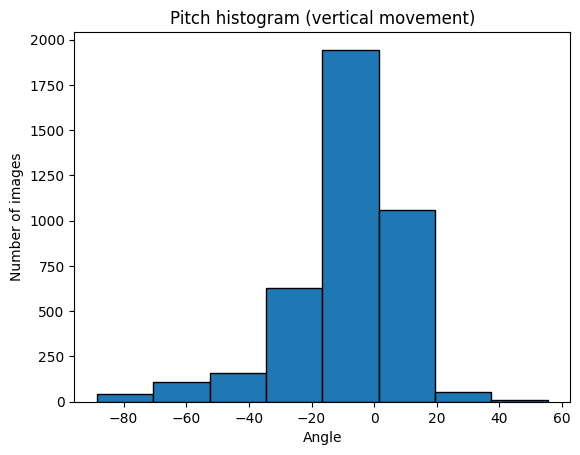

In [ ]:
pitch_array_deg = np.rad2deg(pitch_array)
plt.hist(pitch_array_deg, bins=8, edgecolor='black')
plt.xlabel('Angle')
plt.ylabel('Number of images')
plt.title('Pitch histogram (vertical movement)')
plt.show()

### 1.2.2 Yaw

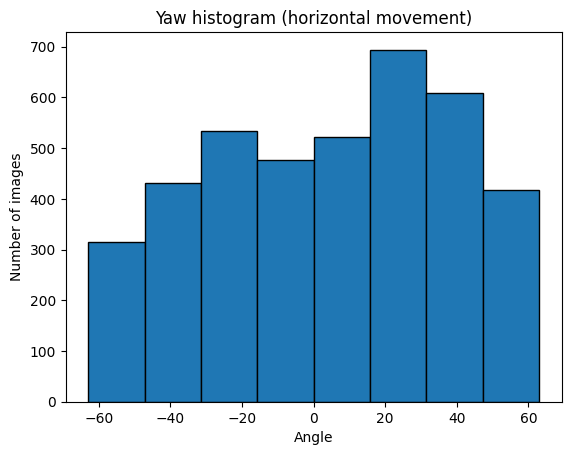

In [ ]:
yaw_array_deg = np.rad2deg(yaw_array)
plt.hist(yaw_array_deg, bins=8, edgecolor='black')
plt.xlabel('Angle')
plt.ylabel('Number of images')
plt.title('Yaw histogram (horizontal movement)')
plt.show()

### 1.2.3 Proyección de ángulos 2D

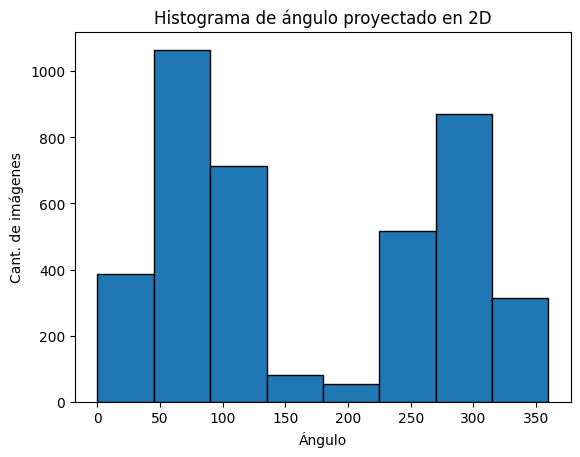

In [ ]:
plt.hist(projected_2d_angle_array, bins=8, edgecolor='black')
plt.xlabel('Ángulo')
plt.ylabel('Cant. de imágenes')
plt.title('Histograma de ángulo proyectado en 2D')
plt.show()

### 1.2.4 Polar plot de pitch y yaw

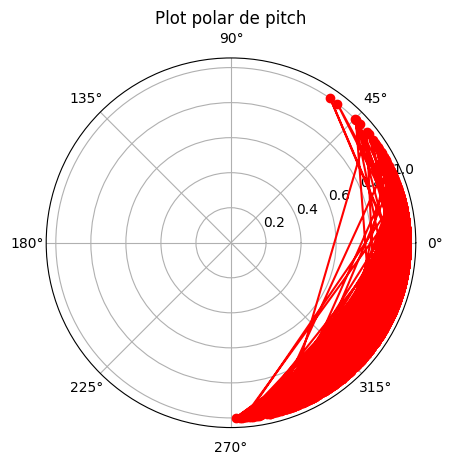

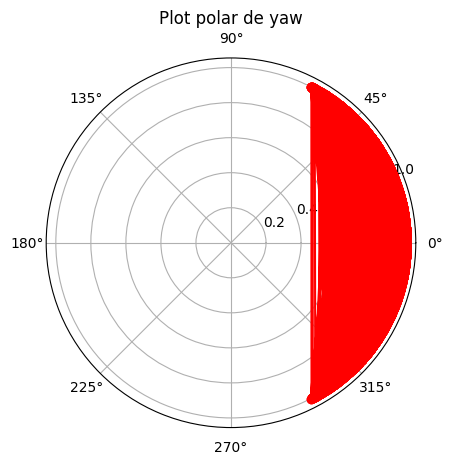

In [ ]:
magnitude_array = np.ones_like(pitch_array)

# Pitch
plt.polar(pitch_array, magnitude_array, marker='o', linestyle='-', color='r')
plt.title('Plot polar de pitch')
# Show the plot
plt.show()

# Yaw
plt.polar(yaw_array, magnitude_array, marker='o', linestyle='-', color='r')
plt.title('Plot polar de yaw')
# Show the plot
plt.show()

### 1.2.5 Distribution of pitch and yaw together



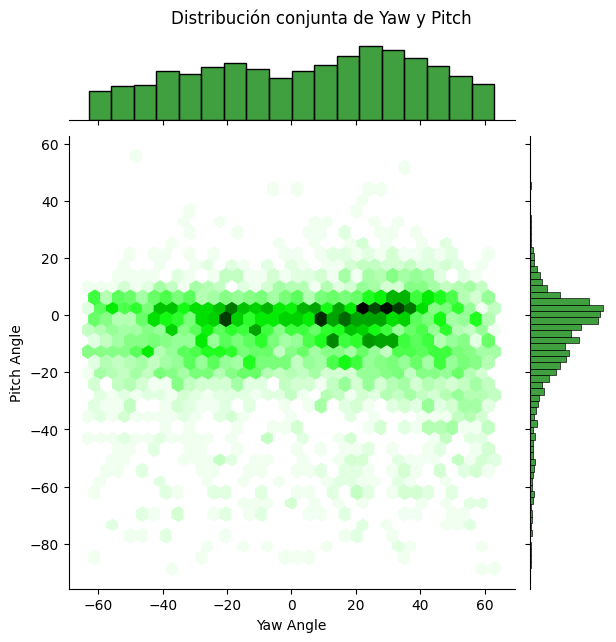

In [ ]:
import seaborn as sns

sns.jointplot(x=yaw_array_deg, y=pitch_array_deg, kind="hex", color="g")
plt.xlabel('Yaw Angle')
plt.ylabel('Pitch Angle')
plt.suptitle('Distribución conjunta de Yaw y Pitch', y=1.03)
plt.show()

## 2. Dataset preparation

- To make things easier we create a class inherited for torch.utils.Dataset. Asociated code is inside _datasets.py_

## 2.1 Data augmentation

- Image are resized to 224x224 to use pre-trained models (most are pre-trained on imagenet).
- Data augmentation:
    - RandomResizedCrop: Crop and zoom images randomly.
    - ColorJitter: Slight changes on hue and saturation to take into account light changes.
    - HorizontalFlip or VerticalFlip can't be used because they alter eye gaze.

In [135]:
WIDTH = 90
HEIGHT = 20

# Transformación de tamaño y data augmentation
data_transforms = transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((HEIGHT, WIDTH)),
    torchvision.transforms.GaussianBlur(kernel_size=5, sigma=(0.05,0.10)),
    # torchvision.transforms.RandomHorizontalFlip(0.5), # No se puede usar aqui porque altera la dirección de la mirada
    # torchvision.transforms.RandomVerticalFlip(0.5), # No se puede usar aqui porque altera la dirección de la mirada
    # torchvision.transforms.RandomResizedCrop(size=(WIDTH, HEIGHT), scale=(0.9, 1.0)),
    # torchvision.transforms.RandomErasing(p=0.1,scale=(0.02,0.08),ratio=(1,1.7),value="random"),
    torchvision.transforms.ColorJitter(saturation=0.1, hue=0.1),
    # torchvision.transforms.Normalize(mean=[0.2740, 0.2626, 0.2639],std=[0.1757, 0.1787, 0.1761]),
])


In [136]:
%%capture
# Ahora sí cargamos todas las imágenes que se van a utilizar en el entrenamiento
ds = Gaze360Dataset("./datasets/Gaze360/",images_limit=7000,random=True,transform=data_transforms,yaw_limits=[-1.1,1.1],face_only=True)
print(f"{len(ds)} images were loaded")

I0000 00:00:1734360770.744644 1087477 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1734360770.753000 1166584 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.6-1), renderer: llvmpipe (LLVM 19.1.3, 256 bits)
W0000 00:00:1734360770.760784 1166580 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1734360770.776694 1166582 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1734360770.803738 1087477 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1734360770.817765 1166589 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.6-1), renderer: llvmpipe (LLVM 19.1.3, 256 bits)
W0000 00:00:1734360770.821176 1166587 inference_feedback_manager.cc:114] Feedback manager requires a model with a single sig

## 2.2 Train and test datasets

In [137]:
# (70% train, 30% test)
train_size = int(0.7*len(ds))  
test_size = len(ds)-train_size

train_dataset, test_dataset = random_split(ds, [train_size, test_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=24, shuffle=True)


Shapes: torch.Size([24, 3, 20, 90]) torch.Size([24, 2])
pitch yaw: tensor([ 1.0222, -0.5935], dtype=torch.float64)


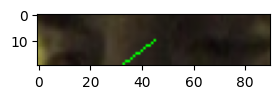

In [138]:
# Visualize a sample
train_image, train_labels = next(iter(train_loader))

print("Shapes:",train_image.shape, train_labels.shape)

# Plot with annotations over it
ii = 0
img = train_image[ii]
# img = inverse_normalize(img,mean=torch.tensor([0.2740, 0.2626, 0.2639]),std=torch.tensor([0.1757, 0.1787, 0.1761]))
img = img.permute(1, 2, 0)
img = (img.numpy()*255).astype(np.uint8)
lbl = train_labels[ii]
height,width,_ = img.shape
img_annotated = draw_gaze360_arrow(img,lbl,[int(width/2),int(height/2)],scale=80)
plt.figure(figsize=(3,3))
plt.imshow(img_annotated)
print(f'pitch yaw: {lbl}')

Aux: Calculate mean and std of this dataset

In [24]:
# Variables to store the sums
mean = 0.
std = 0.
n_samples = 0.

for images, _ in val_loader:
    batch_samples = images.size(0)  # batch size (the last batch can have smaller size)
    images = images.view(batch_samples, images.size(1), -1)  # flatten image channels
    mean += images.mean(2).sum(0)  # sum across batch and spatial dimensions
    std += images.std(2).sum(0)
    n_samples += batch_samples

# Final mean and std
mean /= n_samples
std /= n_samples

print(f'Mean: {mean}')
print(f'Std: {std}')

# Mean: tensor([0.2695, 0.2611, 0.2635])
# Std: tensor([0.1749, 0.1787, 0.1769])

Mean: tensor([0.3058, 0.2605, 0.2465])
Std: tensor([0.0990, 0.0926, 0.0879])


# 3. Models

We are going to test these models:

- Model based on ResNet18:
    - Using transfer learning
    - Parameters of first layers are freezed.
    - Two fully connected layers added at the end
      
- Model based on MobileNetV2:
    - Same procedure as in resnet case
      
      

## 3.4 Model based on MobileNet

### 3.4.1 Instantiation

In [139]:
# Instantiate and configure model
model_mobilenet = GazeEstimation_MobileNet(name="gaze360/mobilenet__epochs_80__lr_1Em3__filtered__eyes",pretrained=True, debug=False) #Debug=True show trainable layers
model_mobilenet.dynamic_lr = True
model_mobilenet.minimum_lr = 1e-6
model_mobilenet.lr_adjustment_ratio = 0.3
model_mobilenet.lr_epochs_adjustment = 60 # Reduce learning rate by 0.3 every 40 epochs

# MSELoss for regression problem
criterion = nn.MSELoss()

# Optimizer: Adam
optimizer = torch.optim.Adam(model_mobilenet.parameters(), lr=1e-3)

#Summary
summary(model_mobilenet.to(device), input_size=(3, 90, 20))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 45, 10]             864
       BatchNorm2d-2           [-1, 32, 45, 10]              64
             ReLU6-3           [-1, 32, 45, 10]               0
            Conv2d-4           [-1, 32, 45, 10]             288
       BatchNorm2d-5           [-1, 32, 45, 10]              64
             ReLU6-6           [-1, 32, 45, 10]               0
            Conv2d-7           [-1, 16, 45, 10]             512
       BatchNorm2d-8           [-1, 16, 45, 10]              32
  InvertedResidual-9           [-1, 16, 45, 10]               0
           Conv2d-10           [-1, 96, 45, 10]           1,536
      BatchNorm2d-11           [-1, 96, 45, 10]             192
            ReLU6-12           [-1, 96, 45, 10]               0
           Conv2d-13            [-1, 96, 23, 5]             864
      BatchNorm2d-14            [-1, 96

### 3.4.2 Training

In [140]:
model_mobilenet.fit(train_loader, val_loader, criterion, optimizer, epochs=80, device=device, save_model=True)

Epoch 1/80


Validation loss 0.09907: 100%|██████████| 88/88 [00:13<00:00,  6.50it/s]


[Lr:0.001] Training Loss / Accuracy: 0.1270 / 36.95% | Validation Loss / Accuracy: 0.0991 / 45.27%
Epoch 2/80


Validation loss 0.07163: 100%|██████████| 88/88 [00:16<00:00,  5.26it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_80__lr_1Em3__filtered__eyes.pth
[Lr:0.001] Training Loss / Accuracy: 0.0758 / 52.24% | Validation Loss / Accuracy: 0.0716 / 55.82%
Epoch 3/80


Validation loss 0.05802: 100%|██████████| 88/88 [00:14<00:00,  6.02it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_80__lr_1Em3__filtered__eyes.pth
[Lr:0.001] Training Loss / Accuracy: 0.0586 / 57.70% | Validation Loss / Accuracy: 0.0580 / 59.19%
Epoch 4/80


Validation loss 0.06002: 100%|██████████| 88/88 [00:13<00:00,  6.46it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0459 / 62.62% | Validation Loss / Accuracy: 0.0600 / 57.77%
Epoch 5/80


Validation loss 0.05943: 100%|██████████| 88/88 [00:12<00:00,  6.93it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0395 / 65.47% | Validation Loss / Accuracy: 0.0594 / 57.53%
Epoch 6/80


Validation loss 0.04960: 100%|██████████| 88/88 [00:13<00:00,  6.40it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_80__lr_1Em3__filtered__eyes.pth
[Lr:0.001] Training Loss / Accuracy: 0.0349 / 68.29% | Validation Loss / Accuracy: 0.0496 / 65.29%
Epoch 7/80


Validation loss 0.05151: 100%|██████████| 88/88 [00:11<00:00,  7.52it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0298 / 70.20% | Validation Loss / Accuracy: 0.0515 / 66.05%
Epoch 8/80


Validation loss 0.04378: 100%|██████████| 88/88 [00:11<00:00,  7.52it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_80__lr_1Em3__filtered__eyes.pth
[Lr:0.001] Training Loss / Accuracy: 0.0285 / 70.65% | Validation Loss / Accuracy: 0.0438 / 68.37%
Epoch 9/80


Validation loss 0.04760: 100%|██████████| 88/88 [00:11<00:00,  7.44it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0272 / 73.27% | Validation Loss / Accuracy: 0.0476 / 66.43%
Epoch 10/80


Validation loss 0.05585: 100%|██████████| 88/88 [00:11<00:00,  7.37it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0262 / 71.79% | Validation Loss / Accuracy: 0.0559 / 65.72%
Epoch 11/80


Validation loss 0.04577: 100%|██████████| 88/88 [00:11<00:00,  7.44it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0228 / 74.94% | Validation Loss / Accuracy: 0.0458 / 67.66%
Epoch 12/80


Validation loss 0.04749: 100%|██████████| 88/88 [00:12<00:00,  6.90it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0217 / 75.81% | Validation Loss / Accuracy: 0.0475 / 64.68%
Epoch 13/80


Validation loss 0.04607: 100%|██████████| 88/88 [00:09<00:00,  8.98it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0213 / 76.16% | Validation Loss / Accuracy: 0.0461 / 68.80%
Epoch 14/80


Validation loss 0.04822: 100%|██████████| 88/88 [00:11<00:00,  7.68it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0202 / 76.89% | Validation Loss / Accuracy: 0.0482 / 66.19%
Epoch 15/80


Validation loss 0.04596: 100%|██████████| 88/88 [00:11<00:00,  7.84it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0186 / 78.94% | Validation Loss / Accuracy: 0.0460 / 65.20%
Epoch 16/80


Validation loss 0.05208: 100%|██████████| 88/88 [00:10<00:00,  8.09it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0382 / 66.38% | Validation Loss / Accuracy: 0.0521 / 61.32%
Epoch 17/80


Validation loss 0.04814: 100%|██████████| 88/88 [00:11<00:00,  7.41it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0307 / 71.24% | Validation Loss / Accuracy: 0.0481 / 66.52%
Epoch 18/80


Validation loss 0.04188: 100%|██████████| 88/88 [00:12<00:00,  7.29it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_80__lr_1Em3__filtered__eyes.pth
[Lr:0.001] Training Loss / Accuracy: 0.0213 / 76.12% | Validation Loss / Accuracy: 0.0419 / 69.60%
Epoch 19/80


Validation loss 0.04348: 100%|██████████| 88/88 [00:12<00:00,  7.19it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0184 / 78.37% | Validation Loss / Accuracy: 0.0435 / 68.47%
Epoch 20/80


Validation loss 0.03824: 100%|██████████| 88/88 [00:09<00:00,  9.43it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_80__lr_1Em3__filtered__eyes.pth
[Lr:0.001] Training Loss / Accuracy: 0.0158 / 80.65% | Validation Loss / Accuracy: 0.0382 / 69.84%
Epoch 21/80


Validation loss 0.04076: 100%|██████████| 88/88 [00:09<00:00,  9.45it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0139 / 82.17% | Validation Loss / Accuracy: 0.0408 / 69.60%
Epoch 22/80


Validation loss 0.03792: 100%|██████████| 88/88 [00:11<00:00,  7.73it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_80__lr_1Em3__filtered__eyes.pth
[Lr:0.001] Training Loss / Accuracy: 0.0132 / 81.87% | Validation Loss / Accuracy: 0.0379 / 69.70%
Epoch 23/80


Validation loss 0.03926: 100%|██████████| 88/88 [00:09<00:00,  8.98it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0127 / 82.42% | Validation Loss / Accuracy: 0.0393 / 70.74%
Epoch 24/80


Validation loss 0.04062: 100%|██████████| 88/88 [00:13<00:00,  6.73it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0123 / 83.39% | Validation Loss / Accuracy: 0.0406 / 70.83%
Epoch 25/80


Validation loss 0.04071: 100%|██████████| 88/88 [00:13<00:00,  6.56it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0120 / 83.68% | Validation Loss / Accuracy: 0.0407 / 70.79%
Epoch 26/80


Validation loss 0.04278: 100%|██████████| 88/88 [00:13<00:00,  6.50it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0115 / 84.23% | Validation Loss / Accuracy: 0.0428 / 69.93%
Epoch 27/80


Validation loss 0.04158: 100%|██████████| 88/88 [00:13<00:00,  6.35it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0121 / 84.19% | Validation Loss / Accuracy: 0.0416 / 70.69%
Epoch 28/80


Validation loss 0.04963: 100%|██████████| 88/88 [00:12<00:00,  6.83it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0184 / 79.19% | Validation Loss / Accuracy: 0.0496 / 64.35%
Epoch 29/80


Validation loss 0.06338: 100%|██████████| 88/88 [00:12<00:00,  7.07it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0208 / 78.01% | Validation Loss / Accuracy: 0.0634 / 58.95%
Epoch 30/80


Validation loss 0.04126: 100%|██████████| 88/88 [00:12<00:00,  7.07it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0202 / 76.89% | Validation Loss / Accuracy: 0.0413 / 67.42%
Epoch 31/80


Validation loss 0.04022: 100%|██████████| 88/88 [00:12<00:00,  7.19it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0192 / 78.11% | Validation Loss / Accuracy: 0.0402 / 69.79%
Epoch 32/80


Validation loss 0.03769: 100%|██████████| 88/88 [00:13<00:00,  6.53it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_80__lr_1Em3__filtered__eyes.pth
[Lr:0.001] Training Loss / Accuracy: 0.0133 / 83.48% | Validation Loss / Accuracy: 0.0377 / 72.63%
Epoch 33/80


Validation loss 0.03617: 100%|██████████| 88/88 [00:13<00:00,  6.58it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_80__lr_1Em3__filtered__eyes.pth
[Lr:0.001] Training Loss / Accuracy: 0.0110 / 85.35% | Validation Loss / Accuracy: 0.0362 / 74.10%
Epoch 34/80


Validation loss 0.03903: 100%|██████████| 88/88 [00:13<00:00,  6.54it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0100 / 86.04% | Validation Loss / Accuracy: 0.0390 / 72.82%
Epoch 35/80


Validation loss 0.03954: 100%|██████████| 88/88 [00:11<00:00,  7.65it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0137 / 81.93% | Validation Loss / Accuracy: 0.0395 / 71.54%
Epoch 36/80


Validation loss 0.03902: 100%|██████████| 88/88 [00:12<00:00,  6.97it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0106 / 85.71% | Validation Loss / Accuracy: 0.0390 / 72.30%
Epoch 37/80


Validation loss 0.04261: 100%|██████████| 88/88 [00:10<00:00,  8.61it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0118 / 84.39% | Validation Loss / Accuracy: 0.0426 / 67.90%
Epoch 38/80


Validation loss 0.04231: 100%|██████████| 88/88 [00:11<00:00,  8.00it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0107 / 86.20% | Validation Loss / Accuracy: 0.0423 / 71.31%
Epoch 39/80


Validation loss 0.03877: 100%|██████████| 88/88 [00:11<00:00,  7.46it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0106 / 84.80% | Validation Loss / Accuracy: 0.0388 / 72.49%
Epoch 40/80


Validation loss 0.03841: 100%|██████████| 88/88 [00:12<00:00,  7.10it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0090 / 86.79% | Validation Loss / Accuracy: 0.0384 / 72.59%
Epoch 41/80


Validation loss 0.03748: 100%|██████████| 88/88 [00:10<00:00,  8.64it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0084 / 87.66% | Validation Loss / Accuracy: 0.0375 / 74.91%
Epoch 42/80


Validation loss 0.03725: 100%|██████████| 88/88 [00:10<00:00,  8.66it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0075 / 88.27% | Validation Loss / Accuracy: 0.0373 / 73.86%
Epoch 43/80


Validation loss 0.03970: 100%|██████████| 88/88 [00:09<00:00,  9.75it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0073 / 89.02% | Validation Loss / Accuracy: 0.0397 / 72.21%
Epoch 44/80


Validation loss 0.03726: 100%|██████████| 88/88 [00:09<00:00,  9.77it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0082 / 88.46% | Validation Loss / Accuracy: 0.0373 / 74.34%
Epoch 45/80


Validation loss 0.03721: 100%|██████████| 88/88 [00:13<00:00,  6.69it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0077 / 88.68% | Validation Loss / Accuracy: 0.0372 / 73.25%
Epoch 46/80


Validation loss 0.03842: 100%|██████████| 88/88 [00:09<00:00,  9.32it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0073 / 88.54% | Validation Loss / Accuracy: 0.0384 / 73.82%
Epoch 47/80


Validation loss 0.04872: 100%|██████████| 88/88 [00:09<00:00,  9.33it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0153 / 81.14% | Validation Loss / Accuracy: 0.0487 / 65.15%
Epoch 48/80


Validation loss 0.05005: 100%|██████████| 88/88 [00:09<00:00,  9.15it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0233 / 76.81% | Validation Loss / Accuracy: 0.0501 / 65.67%
Epoch 49/80


Validation loss 0.03888: 100%|██████████| 88/88 [00:09<00:00,  8.87it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0195 / 79.17% | Validation Loss / Accuracy: 0.0389 / 72.25%
Epoch 50/80


Validation loss 0.03716: 100%|██████████| 88/88 [00:12<00:00,  6.99it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0111 / 84.59% | Validation Loss / Accuracy: 0.0372 / 74.48%
Epoch 51/80


Validation loss 0.03749: 100%|██████████| 88/88 [00:12<00:00,  7.14it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0083 / 87.91% | Validation Loss / Accuracy: 0.0375 / 74.34%
Epoch 52/80


Validation loss 0.03584: 100%|██████████| 88/88 [00:11<00:00,  7.70it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_80__lr_1Em3__filtered__eyes.pth
[Lr:0.001] Training Loss / Accuracy: 0.0082 / 88.11% | Validation Loss / Accuracy: 0.0358 / 75.43%
Epoch 53/80


Validation loss 0.03614: 100%|██████████| 88/88 [00:12<00:00,  7.10it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0066 / 89.65% | Validation Loss / Accuracy: 0.0361 / 73.96%
Epoch 54/80


Validation loss 0.03634: 100%|██████████| 88/88 [00:10<00:00,  8.23it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0062 / 89.90% | Validation Loss / Accuracy: 0.0363 / 73.96%
Epoch 55/80


Validation loss 0.03601: 100%|██████████| 88/88 [00:09<00:00,  9.68it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0066 / 89.88% | Validation Loss / Accuracy: 0.0360 / 73.86%
Epoch 56/80


Validation loss 0.03684: 100%|██████████| 88/88 [00:11<00:00,  7.63it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0060 / 90.63% | Validation Loss / Accuracy: 0.0368 / 75.14%
Epoch 57/80


Validation loss 0.03799: 100%|██████████| 88/88 [00:10<00:00,  8.51it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0057 / 90.93% | Validation Loss / Accuracy: 0.0380 / 73.11%
Epoch 58/80


Validation loss 0.03507: 100%|██████████| 88/88 [00:11<00:00,  7.97it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_80__lr_1Em3__filtered__eyes.pth
[Lr:0.001] Training Loss / Accuracy: 0.0056 / 90.85% | Validation Loss / Accuracy: 0.0351 / 74.62%
Epoch 59/80


Validation loss 0.03771: 100%|██████████| 88/88 [00:10<00:00,  8.73it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0054 / 91.85% | Validation Loss / Accuracy: 0.0377 / 75.28%
Epoch 60/80


Validation loss 0.03549: 100%|██████████| 88/88 [00:10<00:00,  8.28it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0041 / 92.68% | Validation Loss / Accuracy: 0.0355 / 75.24%
Epoch 61/80


Validation loss 0.03484: 100%|██████████| 88/88 [00:12<00:00,  7.06it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_80__lr_1Em3__filtered__eyes.pth
[Lr:0.0003] Training Loss / Accuracy: 0.0032 / 93.19% | Validation Loss / Accuracy: 0.0348 / 75.52%
Epoch 62/80


Validation loss 0.03465: 100%|██████████| 88/88 [00:10<00:00,  8.23it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/gaze360/mobilenet__epochs_80__lr_1Em3__filtered__eyes.pth
[Lr:0.0003] Training Loss / Accuracy: 0.0030 / 94.02% | Validation Loss / Accuracy: 0.0346 / 76.47%
Epoch 63/80


Validation loss 0.03528: 100%|██████████| 88/88 [00:10<00:00,  8.63it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0029 / 94.33% | Validation Loss / Accuracy: 0.0353 / 76.47%
Epoch 64/80


Validation loss 0.03527: 100%|██████████| 88/88 [00:09<00:00,  9.59it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0025 / 94.63% | Validation Loss / Accuracy: 0.0353 / 75.90%
Epoch 65/80


Validation loss 0.03485: 100%|██████████| 88/88 [00:10<00:00,  8.49it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0026 / 94.82% | Validation Loss / Accuracy: 0.0348 / 76.28%
Epoch 66/80


Validation loss 0.03563: 100%|██████████| 88/88 [00:12<00:00,  7.16it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0024 / 94.90% | Validation Loss / Accuracy: 0.0356 / 76.47%
Epoch 67/80


Validation loss 0.03505: 100%|██████████| 88/88 [00:09<00:00,  9.07it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0023 / 94.70% | Validation Loss / Accuracy: 0.0350 / 77.08%
Epoch 68/80


Validation loss 0.03613: 100%|██████████| 88/88 [00:10<00:00,  8.59it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0023 / 94.82% | Validation Loss / Accuracy: 0.0361 / 76.85%
Epoch 69/80


Validation loss 0.03557: 100%|██████████| 88/88 [00:08<00:00,  9.94it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0022 / 95.28% | Validation Loss / Accuracy: 0.0356 / 74.95%
Epoch 70/80


Validation loss 0.03527: 100%|██████████| 88/88 [00:11<00:00,  7.53it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0022 / 95.26% | Validation Loss / Accuracy: 0.0353 / 76.61%
Epoch 71/80


Validation loss 0.03668: 100%|██████████| 88/88 [00:11<00:00,  7.40it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0023 / 95.06% | Validation Loss / Accuracy: 0.0367 / 76.47%
Epoch 72/80


Validation loss 0.03597: 100%|██████████| 88/88 [00:10<00:00,  8.76it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0022 / 95.55% | Validation Loss / Accuracy: 0.0360 / 76.18%
Epoch 73/80


Validation loss 0.03568: 100%|██████████| 88/88 [00:08<00:00, 10.00it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0021 / 95.79% | Validation Loss / Accuracy: 0.0357 / 75.57%
Epoch 74/80


Validation loss 0.03611: 100%|██████████| 88/88 [00:10<00:00,  8.80it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0022 / 95.63% | Validation Loss / Accuracy: 0.0361 / 76.37%
Epoch 75/80


Validation loss 0.03642: 100%|██████████| 88/88 [00:11<00:00,  7.60it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0023 / 95.30% | Validation Loss / Accuracy: 0.0364 / 75.09%
Epoch 76/80


Validation loss 0.03614: 100%|██████████| 88/88 [00:09<00:00,  9.36it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0022 / 95.33% | Validation Loss / Accuracy: 0.0361 / 75.66%
Epoch 77/80


Validation loss 0.03572: 100%|██████████| 88/88 [00:13<00:00,  6.43it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0021 / 95.37% | Validation Loss / Accuracy: 0.0357 / 76.23%
Epoch 78/80


Validation loss 0.03562: 100%|██████████| 88/88 [00:12<00:00,  7.18it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0021 / 95.12% | Validation Loss / Accuracy: 0.0356 / 75.99%
Epoch 79/80


Validation loss 0.03608: 100%|██████████| 88/88 [00:12<00:00,  7.09it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0019 / 95.79% | Validation Loss / Accuracy: 0.0361 / 77.37%
Epoch 80/80


Validation loss 0.03781: 100%|██████████| 88/88 [00:12<00:00,  7.16it/s]

[Lr:0.0003] Training Loss / Accuracy: 0.0020 / 95.51% | Validation Loss / Accuracy: 0.0378 / 75.71%


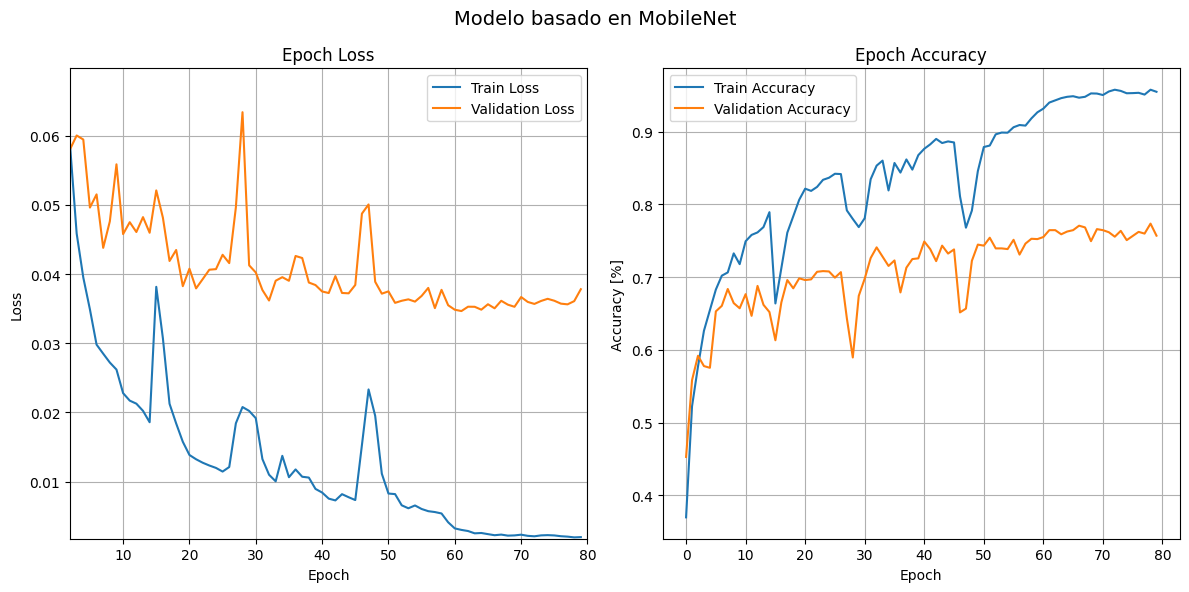

In [141]:
plot_metrics(model_mobilenet, title="Modelo basado en MobileNet")

## 3.6 Model based on Resnet18 with splitted outputs and all parameters trainable

### 3.6.1 Instantiation

In [147]:
# Instanciación del modelo con ResNet18
model_resnet18BTrainable = GazeEstimation_ResNet18Branch(name="resnet18branch__epochs_70__lr_1em4__eyes_extended",n_last_fc=400,n_branch_fc=75, pretrained=True, trainable=True, debug=False) #Debug en True para ver qué capas son entrenables y cuáles no
model_resnet18BTrainable.dynamic_lr = True
model_resnet18BTrainable.minimum_lr = 1e-7
model_resnet18BTrainable.lr_epochs_adjustment = 60 # Cada 60 epochs se reduce el learning rate por un factor de 0.1

# Al ser un problema de regresión se usa MSELoss
criterion = nn.MSELoss()

# Optimizador: Adam
optimizer = torch.optim.Adam(model_resnet18BTrainable.parameters(), lr=1e-4)

#Summary
summary(model_resnet18BTrainable.to(device), input_size=(3, 90, 20))

/home/idk/git/ceia/vpc2_project/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/idk/git/ceia/vpc2_project/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 45, 10]           9,408
       BatchNorm2d-2           [-1, 64, 45, 10]             128
              ReLU-3           [-1, 64, 45, 10]               0
         MaxPool2d-4            [-1, 64, 23, 5]               0
            Conv2d-5            [-1, 64, 23, 5]          36,864
       BatchNorm2d-6            [-1, 64, 23, 5]             128
              ReLU-7            [-1, 64, 23, 5]               0
            Conv2d-8            [-1, 64, 23, 5]          36,864
       BatchNorm2d-9            [-1, 64, 23, 5]             128
             ReLU-10            [-1, 64, 23, 5]               0
       BasicBlock-11            [-1, 64, 23, 5]               0
           Conv2d-12            [-1, 64, 23, 5]          36,864
      BatchNorm2d-13            [-1, 64, 23, 5]             128
             ReLU-14            [-1, 64

### 3.6.2 Training

In [148]:
model_resnet18BTrainable.fit(train_loader, val_loader, criterion, optimizer, epochs=140, device=device, save_model=True)

Epoch 1/140


  0%|          | 0/205 [00:00<?, ?it/s]

Validation loss 0.08376: 100%|██████████| 88/88 [00:16<00:00,  5.28it/s]


[Lr:0.0001] Training Loss / Accuracy: 0.1286 / 36.08% | Validation Loss / Accuracy: 0.0838 / 46.31%
Epoch 2/140


Validation loss 0.06855: 100%|██████████| 88/88 [00:17<00:00,  5.07it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18branch__epochs_70__lr_1em4__eyes_extended.pth
[Lr:0.0001] Training Loss / Accuracy: 0.0713 / 53.39% | Validation Loss / Accuracy: 0.0685 / 56.16%
Epoch 3/140


Validation loss 0.05528: 100%|██████████| 88/88 [00:16<00:00,  5.45it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18branch__epochs_70__lr_1em4__eyes_extended.pth
[Lr:0.0001] Training Loss / Accuracy: 0.0533 / 59.51% | Validation Loss / Accuracy: 0.0553 / 60.56%
Epoch 4/140


Validation loss 0.05310: 100%|██████████| 88/88 [00:16<00:00,  5.27it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18branch__epochs_70__lr_1em4__eyes_extended.pth
[Lr:0.0001] Training Loss / Accuracy: 0.0440 / 64.57% | Validation Loss / Accuracy: 0.0531 / 64.58%
Epoch 5/140


Validation loss 0.05069: 100%|██████████| 88/88 [00:17<00:00,  5.02it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18branch__epochs_70__lr_1em4__eyes_extended.pth
[Lr:0.0001] Training Loss / Accuracy: 0.0344 / 67.58% | Validation Loss / Accuracy: 0.0507 / 62.69%
Epoch 6/140


Validation loss 0.04778: 100%|██████████| 88/88 [00:17<00:00,  5.01it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18branch__epochs_70__lr_1em4__eyes_extended.pth
[Lr:0.0001] Training Loss / Accuracy: 0.0278 / 71.24% | Validation Loss / Accuracy: 0.0478 / 64.96%
Epoch 7/140


Validation loss 0.04416: 100%|██████████| 88/88 [00:17<00:00,  5.07it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18branch__epochs_70__lr_1em4__eyes_extended.pth
[Lr:0.0001] Training Loss / Accuracy: 0.0252 / 73.52% | Validation Loss / Accuracy: 0.0442 / 68.04%
Epoch 8/140


Validation loss 0.04336: 100%|██████████| 88/88 [00:17<00:00,  5.08it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18branch__epochs_70__lr_1em4__eyes_extended.pth
[Lr:0.0001] Training Loss / Accuracy: 0.0219 / 75.51% | Validation Loss / Accuracy: 0.0434 / 67.85%
Epoch 9/140


Validation loss 0.04431: 100%|██████████| 88/88 [00:18<00:00,  4.86it/s]


[Lr:0.0001] Training Loss / Accuracy: 0.0211 / 76.73% | Validation Loss / Accuracy: 0.0443 / 68.47%
Epoch 10/140


Validation loss 0.04046: 100%|██████████| 88/88 [00:17<00:00,  5.02it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18branch__epochs_70__lr_1em4__eyes_extended.pth
[Lr:0.0001] Training Loss / Accuracy: 0.0182 / 78.86% | Validation Loss / Accuracy: 0.0405 / 69.37%
Epoch 11/140


Validation loss 0.04260: 100%|██████████| 88/88 [00:18<00:00,  4.84it/s]


[Lr:0.0001] Training Loss / Accuracy: 0.0166 / 80.24% | Validation Loss / Accuracy: 0.0426 / 67.61%
Epoch 12/140


Validation loss 0.04038: 100%|██████████| 88/88 [00:16<00:00,  5.34it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18branch__epochs_70__lr_1em4__eyes_extended.pth
[Lr:0.0001] Training Loss / Accuracy: 0.0165 / 80.37% | Validation Loss / Accuracy: 0.0404 / 70.60%
Epoch 13/140


Validation loss 0.04033: 100%|██████████| 88/88 [00:14<00:00,  6.10it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18branch__epochs_70__lr_1em4__eyes_extended.pth
[Lr:0.0001] Training Loss / Accuracy: 0.0161 / 81.83% | Validation Loss / Accuracy: 0.0403 / 69.93%
Epoch 14/140


Validation loss 0.03827: 100%|██████████| 88/88 [00:14<00:00,  6.21it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18branch__epochs_70__lr_1em4__eyes_extended.pth
[Lr:0.0001] Training Loss / Accuracy: 0.0145 / 82.80% | Validation Loss / Accuracy: 0.0383 / 69.27%
Epoch 15/140


Validation loss 0.03981: 100%|██████████| 88/88 [00:15<00:00,  5.83it/s]


[Lr:0.0001] Training Loss / Accuracy: 0.0140 / 83.82% | Validation Loss / Accuracy: 0.0398 / 70.12%
Epoch 16/140


Validation loss 0.03748: 100%|██████████| 88/88 [00:16<00:00,  5.40it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18branch__epochs_70__lr_1em4__eyes_extended.pth
[Lr:0.0001] Training Loss / Accuracy: 0.0134 / 83.80% | Validation Loss / Accuracy: 0.0375 / 72.54%
Epoch 17/140


Validation loss 0.03874: 100%|██████████| 88/88 [00:15<00:00,  5.69it/s]


[Lr:0.0001] Training Loss / Accuracy: 0.0129 / 84.86% | Validation Loss / Accuracy: 0.0387 / 70.79%
Epoch 18/140


Validation loss 0.03885: 100%|██████████| 88/88 [00:16<00:00,  5.42it/s]


[Lr:0.0001] Training Loss / Accuracy: 0.0122 / 85.06% | Validation Loss / Accuracy: 0.0388 / 73.34%
Epoch 19/140


Validation loss 0.03699: 100%|██████████| 88/88 [00:17<00:00,  5.05it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18branch__epochs_70__lr_1em4__eyes_extended.pth
[Lr:0.0001] Training Loss / Accuracy: 0.0114 / 85.37% | Validation Loss / Accuracy: 0.0370 / 72.77%
Epoch 20/140


Validation loss 0.03923: 100%|██████████| 88/88 [00:17<00:00,  4.92it/s]


[Lr:0.0001] Training Loss / Accuracy: 0.0109 / 86.48% | Validation Loss / Accuracy: 0.0392 / 69.41%
Epoch 21/140


Validation loss 0.03715: 100%|██████████| 88/88 [00:18<00:00,  4.81it/s]


[Lr:0.0001] Training Loss / Accuracy: 0.0109 / 87.01% | Validation Loss / Accuracy: 0.0371 / 73.63%
Epoch 22/140


Validation loss 0.03665: 100%|██████████| 88/88 [00:16<00:00,  5.27it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18branch__epochs_70__lr_1em4__eyes_extended.pth
[Lr:0.0001] Training Loss / Accuracy: 0.0098 / 87.52% | Validation Loss / Accuracy: 0.0366 / 74.01%
Epoch 23/140


Validation loss 0.03645: 100%|██████████| 88/88 [00:16<00:00,  5.35it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18branch__epochs_70__lr_1em4__eyes_extended.pth
[Lr:0.0001] Training Loss / Accuracy: 0.0101 / 86.75% | Validation Loss / Accuracy: 0.0365 / 71.54%
Epoch 24/140


Validation loss 0.03576: 100%|██████████| 88/88 [00:16<00:00,  5.22it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18branch__epochs_70__lr_1em4__eyes_extended.pth
[Lr:0.0001] Training Loss / Accuracy: 0.0098 / 87.36% | Validation Loss / Accuracy: 0.0358 / 74.20%
Epoch 25/140


Validation loss 0.03486: 100%|██████████| 88/88 [00:17<00:00,  4.94it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18branch__epochs_70__lr_1em4__eyes_extended.pth
[Lr:0.0001] Training Loss / Accuracy: 0.0094 / 88.43% | Validation Loss / Accuracy: 0.0349 / 74.67%
Epoch 26/140


Validation loss 0.03513: 100%|██████████| 88/88 [00:17<00:00,  5.00it/s]


[Lr:0.0001] Training Loss / Accuracy: 0.0092 / 88.15% | Validation Loss / Accuracy: 0.0351 / 72.54%
Epoch 27/140


Validation loss 0.03529: 100%|██████████| 88/88 [00:17<00:00,  4.99it/s]


[Lr:0.0001] Training Loss / Accuracy: 0.0085 / 88.39% | Validation Loss / Accuracy: 0.0353 / 74.34%
Epoch 28/140


Validation loss 0.03686: 100%|██████████| 88/88 [00:18<00:00,  4.64it/s]


[Lr:0.0001] Training Loss / Accuracy: 0.0101 / 87.17% | Validation Loss / Accuracy: 0.0369 / 71.97%
Epoch 29/140


Validation loss 0.03576: 100%|██████████| 88/88 [00:20<00:00,  4.35it/s]


[Lr:0.0001] Training Loss / Accuracy: 0.0087 / 88.13% | Validation Loss / Accuracy: 0.0358 / 74.95%
Epoch 30/140


Validation loss 0.03533: 100%|██████████| 88/88 [00:19<00:00,  4.62it/s]


[Lr:0.0001] Training Loss / Accuracy: 0.0078 / 89.35% | Validation Loss / Accuracy: 0.0353 / 74.29%
Epoch 31/140


Validation loss 0.03383: 100%|██████████| 88/88 [00:14<00:00,  6.14it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18branch__epochs_70__lr_1em4__eyes_extended.pth
[Lr:0.0001] Training Loss / Accuracy: 0.0072 / 90.33% | Validation Loss / Accuracy: 0.0338 / 74.20%
Epoch 32/140


Validation loss 0.03634: 100%|██████████| 88/88 [00:14<00:00,  5.96it/s]


[Lr:0.0001] Training Loss / Accuracy: 0.0075 / 89.55% | Validation Loss / Accuracy: 0.0363 / 73.91%
Epoch 33/140


Validation loss 0.03530: 100%|██████████| 88/88 [00:15<00:00,  5.54it/s]


[Lr:0.0001] Training Loss / Accuracy: 0.0080 / 89.74% | Validation Loss / Accuracy: 0.0353 / 74.15%
Epoch 34/140


Validation loss 0.03578: 100%|██████████| 88/88 [00:18<00:00,  4.72it/s]


[Lr:0.0001] Training Loss / Accuracy: 0.0070 / 90.63% | Validation Loss / Accuracy: 0.0358 / 74.34%
Epoch 35/140


Validation loss 0.03403: 100%|██████████| 88/88 [00:15<00:00,  5.76it/s]


[Lr:0.0001] Training Loss / Accuracy: 0.0065 / 90.85% | Validation Loss / Accuracy: 0.0340 / 75.09%
Epoch 36/140


Validation loss 0.03555: 100%|██████████| 88/88 [00:17<00:00,  5.11it/s]


[Lr:0.0001] Training Loss / Accuracy: 0.0065 / 91.36% | Validation Loss / Accuracy: 0.0355 / 75.76%
Epoch 37/140


Validation loss 0.03510: 100%|██████████| 88/88 [00:16<00:00,  5.49it/s]


[Lr:0.0001] Training Loss / Accuracy: 0.0060 / 91.79% | Validation Loss / Accuracy: 0.0351 / 74.24%
Epoch 38/140


Validation loss 0.03360: 100%|██████████| 88/88 [00:18<00:00,  4.81it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18branch__epochs_70__lr_1em4__eyes_extended.pth
[Lr:0.0001] Training Loss / Accuracy: 0.0058 / 92.26% | Validation Loss / Accuracy: 0.0336 / 75.28%
Epoch 39/140


Validation loss 0.03433: 100%|██████████| 88/88 [00:18<00:00,  4.74it/s]


[Lr:0.0001] Training Loss / Accuracy: 0.0064 / 91.26% | Validation Loss / Accuracy: 0.0343 / 75.90%
Epoch 40/140


Validation loss 0.03386: 100%|██████████| 88/88 [00:17<00:00,  5.06it/s]


[Lr:0.0001] Training Loss / Accuracy: 0.0063 / 91.85% | Validation Loss / Accuracy: 0.0339 / 74.29%
Epoch 41/140


Validation loss 0.03436: 100%|██████████| 88/88 [00:16<00:00,  5.22it/s]


[Lr:0.0001] Training Loss / Accuracy: 0.0058 / 91.36% | Validation Loss / Accuracy: 0.0344 / 75.14%
Epoch 42/140


Validation loss 0.03236: 100%|██████████| 88/88 [00:16<00:00,  5.33it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18branch__epochs_70__lr_1em4__eyes_extended.pth
[Lr:0.0001] Training Loss / Accuracy: 0.0055 / 91.54% | Validation Loss / Accuracy: 0.0324 / 76.04%
Epoch 43/140


Validation loss 0.03529: 100%|██████████| 88/88 [00:15<00:00,  5.53it/s]


[Lr:0.0001] Training Loss / Accuracy: 0.0057 / 91.54% | Validation Loss / Accuracy: 0.0353 / 73.15%
Epoch 44/140


Validation loss 0.03626: 100%|██████████| 88/88 [00:14<00:00,  6.03it/s]


[Lr:0.0001] Training Loss / Accuracy: 0.0065 / 91.08% | Validation Loss / Accuracy: 0.0363 / 74.43%
Epoch 45/140


Validation loss 0.03253: 100%|██████████| 88/88 [00:14<00:00,  6.07it/s]


[Lr:0.0001] Training Loss / Accuracy: 0.0058 / 91.00% | Validation Loss / Accuracy: 0.0325 / 75.14%
Epoch 46/140


Validation loss 0.03354: 100%|██████████| 88/88 [00:15<00:00,  5.69it/s]


[Lr:0.0001] Training Loss / Accuracy: 0.0050 / 93.01% | Validation Loss / Accuracy: 0.0335 / 75.33%
Epoch 47/140


Validation loss 0.03313: 100%|██████████| 88/88 [00:16<00:00,  5.41it/s]


[Lr:0.0001] Training Loss / Accuracy: 0.0051 / 93.05% | Validation Loss / Accuracy: 0.0331 / 75.99%
Epoch 48/140


Validation loss 0.03298: 100%|██████████| 88/88 [00:16<00:00,  5.36it/s]


[Lr:0.0001] Training Loss / Accuracy: 0.0053 / 91.95% | Validation Loss / Accuracy: 0.0330 / 74.95%
Epoch 49/140


Validation loss 0.03209: 100%|██████████| 88/88 [00:16<00:00,  5.19it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18branch__epochs_70__lr_1em4__eyes_extended.pth
[Lr:0.0001] Training Loss / Accuracy: 0.0054 / 92.60% | Validation Loss / Accuracy: 0.0321 / 75.76%
Epoch 50/140


Validation loss 0.03284: 100%|██████████| 88/88 [00:17<00:00,  5.17it/s]


[Lr:0.0001] Training Loss / Accuracy: 0.0055 / 92.34% | Validation Loss / Accuracy: 0.0328 / 75.28%
Epoch 51/140


Validation loss 0.03288: 100%|██████████| 88/88 [00:16<00:00,  5.28it/s]


[Lr:0.0001] Training Loss / Accuracy: 0.0060 / 91.87% | Validation Loss / Accuracy: 0.0329 / 75.00%
Epoch 52/140


Validation loss 0.03279: 100%|██████████| 88/88 [00:17<00:00,  4.92it/s]


[Lr:0.0001] Training Loss / Accuracy: 0.0050 / 92.48% | Validation Loss / Accuracy: 0.0328 / 73.86%
Epoch 53/140


Validation loss 0.03353: 100%|██████████| 88/88 [00:18<00:00,  4.88it/s]


[Lr:0.0001] Training Loss / Accuracy: 0.0044 / 93.33% | Validation Loss / Accuracy: 0.0335 / 75.57%
Epoch 54/140


Validation loss 0.03274: 100%|██████████| 88/88 [00:17<00:00,  5.10it/s]


[Lr:0.0001] Training Loss / Accuracy: 0.0041 / 93.92% | Validation Loss / Accuracy: 0.0327 / 75.33%
Epoch 55/140


Validation loss 0.03269: 100%|██████████| 88/88 [00:18<00:00,  4.78it/s]


[Lr:0.0001] Training Loss / Accuracy: 0.0042 / 93.70% | Validation Loss / Accuracy: 0.0327 / 75.80%
Epoch 56/140


Validation loss 0.03276: 100%|██████████| 88/88 [00:18<00:00,  4.83it/s]


[Lr:0.0001] Training Loss / Accuracy: 0.0041 / 93.76% | Validation Loss / Accuracy: 0.0328 / 75.76%
Epoch 57/140


Validation loss 0.03475: 100%|██████████| 88/88 [00:16<00:00,  5.28it/s]


[Lr:0.0001] Training Loss / Accuracy: 0.0044 / 93.03% | Validation Loss / Accuracy: 0.0347 / 75.33%
Epoch 58/140


Validation loss 0.03253: 100%|██████████| 88/88 [00:17<00:00,  4.99it/s]


[Lr:0.0001] Training Loss / Accuracy: 0.0042 / 93.82% | Validation Loss / Accuracy: 0.0325 / 75.62%
Epoch 59/140


Validation loss 0.03174: 100%|██████████| 88/88 [00:16<00:00,  5.24it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18branch__epochs_70__lr_1em4__eyes_extended.pth
[Lr:0.0001] Training Loss / Accuracy: 0.0039 / 93.96% | Validation Loss / Accuracy: 0.0317 / 75.80%
Epoch 60/140


Validation loss 0.03137: 100%|██████████| 88/88 [00:16<00:00,  5.29it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18branch__epochs_70__lr_1em4__eyes_extended.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0031 / 94.43% | Validation Loss / Accuracy: 0.0314 / 76.42%
Epoch 61/140


Validation loss 0.03106: 100%|██████████| 88/88 [00:17<00:00,  4.90it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18branch__epochs_70__lr_1em4__eyes_extended.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0027 / 94.57% | Validation Loss / Accuracy: 0.0311 / 77.08%
Epoch 62/140


Validation loss 0.03091: 100%|██████████| 88/88 [00:16<00:00,  5.40it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18branch__epochs_70__lr_1em4__eyes_extended.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0026 / 95.73% | Validation Loss / Accuracy: 0.0309 / 77.56%
Epoch 63/140


Validation loss 0.03079: 100%|██████████| 88/88 [00:16<00:00,  5.33it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18branch__epochs_70__lr_1em4__eyes_extended.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0024 / 95.77% | Validation Loss / Accuracy: 0.0308 / 76.85%
Epoch 64/140


Validation loss 0.03138: 100%|██████████| 88/88 [00:17<00:00,  5.11it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0025 / 95.77% | Validation Loss / Accuracy: 0.0314 / 77.94%
Epoch 65/140


Validation loss 0.03071: 100%|██████████| 88/88 [00:18<00:00,  4.89it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18branch__epochs_70__lr_1em4__eyes_extended.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0023 / 95.71% | Validation Loss / Accuracy: 0.0307 / 77.46%
Epoch 66/140


Validation loss 0.03102: 100%|██████████| 88/88 [00:19<00:00,  4.61it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0022 / 96.16% | Validation Loss / Accuracy: 0.0310 / 77.65%
Epoch 67/140


Validation loss 0.03098: 100%|██████████| 88/88 [00:16<00:00,  5.26it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0022 / 96.02% | Validation Loss / Accuracy: 0.0310 / 76.94%
Epoch 68/140


Validation loss 0.03106: 100%|██████████| 88/88 [00:16<00:00,  5.21it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0021 / 96.30% | Validation Loss / Accuracy: 0.0311 / 76.89%
Epoch 69/140


Validation loss 0.03106: 100%|██████████| 88/88 [00:17<00:00,  5.09it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0020 / 96.26% | Validation Loss / Accuracy: 0.0311 / 77.04%
Epoch 70/140


Validation loss 0.03177: 100%|██████████| 88/88 [00:17<00:00,  5.13it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0020 / 96.20% | Validation Loss / Accuracy: 0.0318 / 76.52%
Epoch 71/140


Validation loss 0.03123: 100%|██████████| 88/88 [00:17<00:00,  5.01it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0020 / 96.38% | Validation Loss / Accuracy: 0.0312 / 76.52%
Epoch 72/140


Validation loss 0.03129: 100%|██████████| 88/88 [00:16<00:00,  5.18it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0020 / 95.96% | Validation Loss / Accuracy: 0.0313 / 78.17%
Epoch 73/140


Validation loss 0.03138: 100%|██████████| 88/88 [00:16<00:00,  5.29it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0019 / 95.91% | Validation Loss / Accuracy: 0.0314 / 77.70%
Epoch 74/140


Validation loss 0.03159: 100%|██████████| 88/88 [00:17<00:00,  4.97it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0020 / 96.52% | Validation Loss / Accuracy: 0.0316 / 77.32%
Epoch 75/140


Validation loss 0.03133: 100%|██████████| 88/88 [00:16<00:00,  5.21it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0019 / 96.52% | Validation Loss / Accuracy: 0.0313 / 77.37%
Epoch 76/140


Validation loss 0.03099: 100%|██████████| 88/88 [00:16<00:00,  5.35it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0018 / 96.36% | Validation Loss / Accuracy: 0.0310 / 77.41%
Epoch 77/140


Validation loss 0.03130: 100%|██████████| 88/88 [00:17<00:00,  5.17it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0018 / 96.52% | Validation Loss / Accuracy: 0.0313 / 77.23%
Epoch 78/140


Validation loss 0.03152: 100%|██████████| 88/88 [00:16<00:00,  5.22it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0018 / 96.69% | Validation Loss / Accuracy: 0.0315 / 77.46%
Epoch 79/140


Validation loss 0.03150: 100%|██████████| 88/88 [00:17<00:00,  5.14it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0017 / 96.52% | Validation Loss / Accuracy: 0.0315 / 76.85%
Epoch 80/140


Validation loss 0.03135: 100%|██████████| 88/88 [00:17<00:00,  5.09it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0018 / 96.48% | Validation Loss / Accuracy: 0.0314 / 77.75%
Epoch 81/140


Validation loss 0.03138: 100%|██████████| 88/88 [00:18<00:00,  4.75it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0018 / 96.18% | Validation Loss / Accuracy: 0.0314 / 77.79%
Epoch 82/140


Validation loss 0.03117: 100%|██████████| 88/88 [00:17<00:00,  5.04it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0017 / 96.97% | Validation Loss / Accuracy: 0.0312 / 77.70%
Epoch 83/140


Validation loss 0.03160: 100%|██████████| 88/88 [00:17<00:00,  5.16it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0018 / 96.63% | Validation Loss / Accuracy: 0.0316 / 77.23%
Epoch 84/140


Validation loss 0.03141: 100%|██████████| 88/88 [00:17<00:00,  5.08it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0019 / 96.30% | Validation Loss / Accuracy: 0.0314 / 77.75%
Epoch 85/140


Validation loss 0.03164: 100%|██████████| 88/88 [00:17<00:00,  5.15it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0017 / 96.50% | Validation Loss / Accuracy: 0.0316 / 77.46%
Epoch 86/140


Validation loss 0.03177: 100%|██████████| 88/88 [00:16<00:00,  5.30it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0017 / 96.65% | Validation Loss / Accuracy: 0.0318 / 77.13%
Epoch 87/140


Validation loss 0.03217: 100%|██████████| 88/88 [00:16<00:00,  5.28it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0018 / 96.75% | Validation Loss / Accuracy: 0.0322 / 77.79%
Epoch 88/140


Validation loss 0.03196: 100%|██████████| 88/88 [00:17<00:00,  5.05it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0017 / 96.89% | Validation Loss / Accuracy: 0.0320 / 77.75%
Epoch 89/140


Validation loss 0.03159: 100%|██████████| 88/88 [00:16<00:00,  5.27it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0017 / 96.87% | Validation Loss / Accuracy: 0.0316 / 76.89%
Epoch 90/140


Validation loss 0.03152: 100%|██████████| 88/88 [00:18<00:00,  4.75it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0016 / 96.87% | Validation Loss / Accuracy: 0.0315 / 77.41%
Epoch 91/140


Validation loss 0.03162: 100%|██████████| 88/88 [00:16<00:00,  5.27it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0015 / 96.85% | Validation Loss / Accuracy: 0.0316 / 77.84%
Epoch 92/140


Validation loss 0.03188: 100%|██████████| 88/88 [00:16<00:00,  5.26it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0016 / 96.83% | Validation Loss / Accuracy: 0.0319 / 77.46%
Epoch 93/140


Validation loss 0.03097: 100%|██████████| 88/88 [00:17<00:00,  4.94it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0016 / 97.05% | Validation Loss / Accuracy: 0.0310 / 77.79%
Epoch 94/140


Validation loss 0.03138: 100%|██████████| 88/88 [00:18<00:00,  4.82it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0016 / 97.01% | Validation Loss / Accuracy: 0.0314 / 77.37%
Epoch 95/140


Validation loss 0.03180: 100%|██████████| 88/88 [00:17<00:00,  5.17it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0016 / 96.89% | Validation Loss / Accuracy: 0.0318 / 76.70%
Epoch 96/140


Validation loss 0.03124: 100%|██████████| 88/88 [00:16<00:00,  5.47it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0015 / 96.77% | Validation Loss / Accuracy: 0.0312 / 77.98%
Epoch 97/140


Validation loss 0.03121: 100%|██████████| 88/88 [00:15<00:00,  5.68it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0016 / 96.95% | Validation Loss / Accuracy: 0.0312 / 77.94%
Epoch 98/140


Validation loss 0.03092: 100%|██████████| 88/88 [00:13<00:00,  6.49it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0017 / 96.79% | Validation Loss / Accuracy: 0.0309 / 77.84%
Epoch 99/140


Validation loss 0.03148: 100%|██████████| 88/88 [00:14<00:00,  5.98it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0016 / 96.63% | Validation Loss / Accuracy: 0.0315 / 78.12%
Epoch 100/140


Validation loss 0.03138: 100%|██████████| 88/88 [00:15<00:00,  5.68it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0015 / 97.13% | Validation Loss / Accuracy: 0.0314 / 77.04%
Epoch 101/140


Validation loss 0.03096: 100%|██████████| 88/88 [00:16<00:00,  5.48it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0016 / 97.30% | Validation Loss / Accuracy: 0.0310 / 78.08%
Epoch 102/140


Validation loss 0.03043: 100%|██████████| 88/88 [00:16<00:00,  5.37it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18branch__epochs_70__lr_1em4__eyes_extended.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0016 / 96.87% | Validation Loss / Accuracy: 0.0304 / 76.89%
Epoch 103/140


Validation loss 0.03145: 100%|██████████| 88/88 [00:16<00:00,  5.30it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0016 / 97.03% | Validation Loss / Accuracy: 0.0314 / 77.94%
Epoch 104/140


Validation loss 0.03186: 100%|██████████| 88/88 [00:16<00:00,  5.30it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0016 / 96.79% | Validation Loss / Accuracy: 0.0319 / 77.94%
Epoch 105/140


Validation loss 0.03112: 100%|██████████| 88/88 [00:15<00:00,  5.78it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0015 / 96.65% | Validation Loss / Accuracy: 0.0311 / 77.32%
Epoch 106/140


Validation loss 0.03217: 100%|██████████| 88/88 [00:16<00:00,  5.42it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0021 / 96.44% | Validation Loss / Accuracy: 0.0322 / 77.75%
Epoch 107/140


Validation loss 0.03145: 100%|██████████| 88/88 [00:29<00:00,  2.98it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0016 / 96.65% | Validation Loss / Accuracy: 0.0314 / 77.23%
Epoch 108/140


Validation loss 0.03116: 100%|██████████| 88/88 [00:17<00:00,  5.06it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0015 / 96.83% | Validation Loss / Accuracy: 0.0312 / 77.56%
Epoch 109/140


Validation loss 0.03169: 100%|██████████| 88/88 [00:18<00:00,  4.86it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0014 / 97.38% | Validation Loss / Accuracy: 0.0317 / 77.23%
Epoch 110/140


Validation loss 0.03121: 100%|██████████| 88/88 [00:17<00:00,  4.92it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0014 / 97.28% | Validation Loss / Accuracy: 0.0312 / 77.56%
Epoch 111/140


Validation loss 0.03155: 100%|██████████| 88/88 [00:16<00:00,  5.34it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0015 / 96.34% | Validation Loss / Accuracy: 0.0316 / 76.99%
Epoch 112/140


Validation loss 0.03181: 100%|██████████| 88/88 [00:16<00:00,  5.27it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0016 / 97.32% | Validation Loss / Accuracy: 0.0318 / 77.27%
Epoch 113/140


Validation loss 0.03169: 100%|██████████| 88/88 [00:15<00:00,  5.58it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0015 / 97.44% | Validation Loss / Accuracy: 0.0317 / 77.70%
Epoch 114/140


Validation loss 0.03193: 100%|██████████| 88/88 [00:21<00:00,  4.01it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0014 / 97.26% | Validation Loss / Accuracy: 0.0319 / 77.75%
Epoch 115/140


Validation loss 0.03135: 100%|██████████| 88/88 [00:14<00:00,  6.08it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0014 / 97.17% | Validation Loss / Accuracy: 0.0314 / 78.08%
Epoch 116/140


Validation loss 0.03200: 100%|██████████| 88/88 [00:15<00:00,  5.54it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0015 / 97.32% | Validation Loss / Accuracy: 0.0320 / 77.51%
Epoch 117/140


Validation loss 0.03145: 100%|██████████| 88/88 [00:17<00:00,  5.07it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0015 / 96.79% | Validation Loss / Accuracy: 0.0315 / 77.51%
Epoch 118/140


Validation loss 0.03128: 100%|██████████| 88/88 [00:17<00:00,  5.00it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0015 / 96.69% | Validation Loss / Accuracy: 0.0313 / 77.84%
Epoch 119/140


Validation loss 0.03241: 100%|██████████| 88/88 [00:18<00:00,  4.79it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0014 / 97.13% | Validation Loss / Accuracy: 0.0324 / 77.65%
Epoch 120/140


Validation loss 0.03167: 100%|██████████| 88/88 [00:19<00:00,  4.53it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0014 / 97.22% | Validation Loss / Accuracy: 0.0317 / 77.56%
Epoch 121/140


Validation loss 0.03169: 100%|██████████| 88/88 [00:16<00:00,  5.23it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0014 / 97.20% | Validation Loss / Accuracy: 0.0317 / 77.94%
Epoch 122/140


Validation loss 0.03133: 100%|██████████| 88/88 [00:17<00:00,  5.16it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0013 / 97.40% | Validation Loss / Accuracy: 0.0313 / 77.37%
Epoch 123/140


Validation loss 0.03178: 100%|██████████| 88/88 [00:18<00:00,  4.87it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0014 / 97.40% | Validation Loss / Accuracy: 0.0318 / 77.98%
Epoch 124/140


Validation loss 0.03140: 100%|██████████| 88/88 [00:17<00:00,  5.06it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0014 / 97.13% | Validation Loss / Accuracy: 0.0314 / 78.22%
Epoch 125/140


Validation loss 0.03188: 100%|██████████| 88/88 [00:18<00:00,  4.82it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0013 / 97.05% | Validation Loss / Accuracy: 0.0319 / 78.03%
Epoch 126/140


Validation loss 0.03198: 100%|██████████| 88/88 [00:17<00:00,  4.92it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0014 / 97.11% | Validation Loss / Accuracy: 0.0320 / 77.56%
Epoch 127/140


Validation loss 0.03214: 100%|██████████| 88/88 [00:16<00:00,  5.27it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0013 / 97.34% | Validation Loss / Accuracy: 0.0321 / 77.51%
Epoch 128/140


Validation loss 0.03197: 100%|██████████| 88/88 [00:16<00:00,  5.28it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0013 / 97.48% | Validation Loss / Accuracy: 0.0320 / 77.56%
Epoch 129/140


Validation loss 0.03189: 100%|██████████| 88/88 [00:18<00:00,  4.84it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0014 / 97.32% | Validation Loss / Accuracy: 0.0319 / 78.22%
Epoch 130/140


Validation loss 0.03099: 100%|██████████| 88/88 [00:16<00:00,  5.38it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0015 / 97.32% | Validation Loss / Accuracy: 0.0310 / 77.65%
Epoch 131/140


Validation loss 0.03210: 100%|██████████| 88/88 [00:17<00:00,  4.92it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0015 / 97.17% | Validation Loss / Accuracy: 0.0321 / 78.12%
Epoch 132/140


Validation loss 0.03165: 100%|██████████| 88/88 [00:18<00:00,  4.81it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0013 / 97.56% | Validation Loss / Accuracy: 0.0316 / 78.17%
Epoch 133/140


Validation loss 0.03138: 100%|██████████| 88/88 [00:17<00:00,  4.94it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0013 / 97.28% | Validation Loss / Accuracy: 0.0314 / 77.56%
Epoch 134/140


Validation loss 0.03212: 100%|██████████| 88/88 [00:17<00:00,  5.09it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0014 / 96.97% | Validation Loss / Accuracy: 0.0321 / 78.22%
Epoch 135/140


Validation loss 0.03227: 100%|██████████| 88/88 [00:16<00:00,  5.22it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0014 / 97.30% | Validation Loss / Accuracy: 0.0323 / 78.17%
Epoch 136/140


Validation loss 0.03134: 100%|██████████| 88/88 [00:15<00:00,  5.53it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0013 / 97.70% | Validation Loss / Accuracy: 0.0313 / 77.79%
Epoch 137/140


Validation loss 0.03136: 100%|██████████| 88/88 [00:13<00:00,  6.50it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0015 / 97.17% | Validation Loss / Accuracy: 0.0314 / 77.04%
Epoch 138/140


Validation loss 0.03163: 100%|██████████| 88/88 [00:14<00:00,  5.96it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0013 / 97.60% | Validation Loss / Accuracy: 0.0316 / 77.60%
Epoch 139/140


Validation loss 0.03156: 100%|██████████| 88/88 [00:14<00:00,  6.16it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0013 / 97.48% | Validation Loss / Accuracy: 0.0316 / 77.27%
Epoch 140/140


Validation loss 0.03218: 100%|██████████| 88/88 [00:13<00:00,  6.64it/s]

[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0013 / 97.03% | Validation Loss / Accuracy: 0.0322 / 77.56%


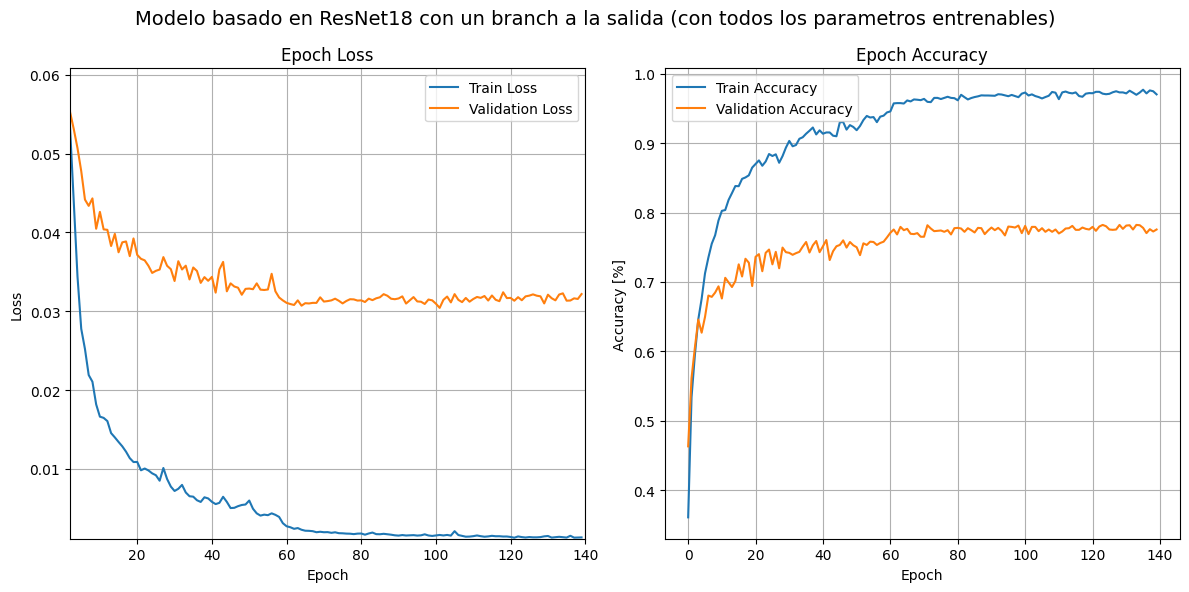

In [149]:
plot_metrics(model_resnet18BTrainable, title="Modelo basado en ResNet18 con un branch a la salida (con todos los parametros entrenables)")

## 4. Validation

Randomly pick an image and compare prediction VS groundtruth
- Blue arrow: real eye gaze.
- Green arrow: predicted eye gaze.

In [259]:
torch.save(model_resnet18BTrainable.state_dict(),"./modelos/resnet18.pth")

In [10]:
# Se elige el mejor modelo para validación
# loaded_model = GazeEstimation_MobileNet()
loaded_model = GazeEstimation_ResNet18Branch(pretrained=False,n_last_fc=400,n_branch_fc=75)

# loaded_model.load_state_dict(torch.load('./modelos/gaze360/mobilenet__epochs_300__lr_1Em4__filtered__face.pth'))
loaded_model.load_state_dict(torch.load('./modelos/resnet18.pth',weights_only=True))
loaded_model.to(device)

# Sanity check
inputs = torch.randn(8, 3, 90, 20).to(device) 
outputs = loaded_model(inputs) 

print(outputs)

/home/idk/git/ceia/vpc2_project/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/idk/git/ceia/vpc2_project/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


tensor([[ 0.5864,  0.0581],
        [-0.2021, -0.0364],
        [ 0.5087,  0.1193],
        [ 0.2618, -0.2959],
        [ 0.4163,  0.0018],
        [-0.0859, -0.2616],
        [ 0.0900, -0.0521],
        [-0.1380, -0.0775]], device='cuda:0', grad_fn=<CatBackward0>)


In [7]:
import time

In [9]:
# Pick model
model = loaded_model

# Randomly select image and its labels
img, gaze = test_dataset[randint(0,len(test_dataset)-1)]
pitch = gaze[0]
yaw = gaze[1]
angle = angle_to_2d(np.array([gaze]))

# Get start time
start_time = time.time()

# Run inference and get prediction
predicted_gaze = model(img.unsqueeze(0).to(device))
pitch_predicted = predicted_gaze[0][0].item()
yaw_predicted = predicted_gaze[0][1].item()
img = img.squeeze(0).detach().cpu().numpy().transpose(1,2,0)
predicted_gaze = predicted_gaze.squeeze(0).detach().cpu().numpy()
angle_predicted = angle_to_2d(np.array([predicted_gaze]))

# Get end time
end_time = time.time()

# Print prediction time
prediction_time = end_time - start_time
print(f"Prediction time: {prediction_time*1000:.2f}ms ")

# Define error tolerance
tolerancia = 20 # 15 degrees
accurate = int(is_accurate(angle,angle_predicted,tolerance=tolerancia)[0])

# Print results
print("Actual: ")
print(f"\t pitch={pitch:.3f} rad | yaw={yaw:.3f} rad")
print(f"\t proyección 2D del ángulo: {angle[0]:.2f}° deg")
print("Predicted: ")
print(f"\t pitch={pitch_predicted:.3f} rad | yaw={yaw_predicted:.3f} rad")
print(f"\t proyección 2D del ángulo: {angle_predicted[0]:.2f}° deg")
print(f"**Preciso (tolerancia = {tolerancia}°): {accurate}")

# Add annotations
plt.figure(figsize=(7,4))
plt.subplot(1,2,1)
plt.imshow(img)
img = draw_gaze360_arrow(img,gaze,"center",scale=80)
img = draw_gaze360_arrow(img,predicted_gaze,"center",color=(255,0,0),scale=200)
# img = put_gaze_annotation(img,predicted_gaze,method=1,color=(0,255,0), label="Predicted",label_y=22) #Prediced: green
# img = put_gaze_annotation(img,gaze,method=1,color=(255,0,0),label="Actual",label_y=10) #Actual: blue

# Show images (after converting it from BGR to RGB)
plt.subplot(1,2,2)
plt.imshow(img)

NameError: name 'loaded_model' is not defined

## 5. Export best model to ONNX


In [291]:
import torch
import torch.onnx

# Assuming your model is already loaded or defined
model = loaded_model  # Replace with your model class
model.eval()  # Switch to evaluation mode

# Example input tensor matching the expected input size of your model
dummy_input = torch.randn(1, 3, 20, 90).to(device)  # Example input shape for CIFAR-10

# Export the model
torch.onnx.export(
    model, 
    dummy_input, 
    "./modelos/onnx/resnet18_face.onnx",  # Output file
    export_params=True,  # Store the trained parameters
    opset_version=11,  # ONNX version
    input_names=['input'],  # Name of the input layer
    output_names=['gaze'],  # Name of the output layer
)


### 5.1 Verify ONNX exported model

I0000 00:00:1734473743.819069 2427877 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1734473743.830875 2472345 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.6-1), renderer: llvmpipe (LLVM 19.1.3, 256 bits)
W0000 00:00:1734473743.839050 2472341 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1734473743.860663 2472342 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


[0.49411765 0.4788235  0.44509804 0.42555556 0.43117648 0.42877996
 0.40442267 0.38333336 0.37771243 0.3672113 ]
PyTorch Output:
[[ 0.13749266 -0.0739852 ]]
ONNX Output:
[array([[-0.5990017 ,  0.01436738]], dtype=float32)]
Are the outputs similar? False


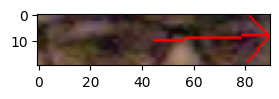

: 

In [ ]:
import torch
import torch.onnx
import onnxruntime as ort
from PIL import Image
from aux_functions import detect_face_bounding_box_from_array,detect_eyes_region_from_array

# Load ONNX model
onnx_model_path = "./modelos/onnx/resnet18_face.onnx"
ort_session = ort.InferenceSession(onnx_model_path)

# Specify the path to your image
# image_path = "/home/idk/Downloads/photo_5010264429970959982_m.jpg"
image_path = "/home/idk/git/ceia/vpc2_project/datasets/Gaze360/imgs/rec_003/head/000165/001249.jpg"
# image_path = "/home/idk/Desktop/canvas.png"

# Define the necessary transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Resize((20, 90)),  # Resize the image to 224x224
])

# Load the image
image = Image.open(image_path).convert('RGB')  # Convert image to RGB
image_face = detect_eyes_region_from_array(np.array(image))

if image_face is not None:
    image_transformed = transform(image_face)

    # Flatten the tensor (in row-major order) to match JavaScript processing
    flattened_img_tensor = image_transformed.contiguous().view(-1).numpy()
    print(flattened_img_tensor[:10])

    # Apply the transformations
    sample_input = image_transformed.unsqueeze(0)  # Add batch dimension



    # Run inference with PyTorch model
    with torch.no_grad():
        pytorch_output = loaded_model(sample_input.to(device))

    # Convert PyTorch tensor to numpy (required for ONNX Runtime)
    sample_input_np = sample_input.numpy()

    # Prepare input for ONNX Runtime
    onnx_inputs = {ort_session.get_inputs()[0].name: sample_input_np}

    # Run inference with ONNX model
    onnx_output = ort_session.run(None, onnx_inputs)

    # Compare outputs
    pytorch_output_np = pytorch_output.detach().cpu().numpy()

    print("PyTorch Output:")
    print(pytorch_output_np)

    print("ONNX Output:")
    print(onnx_output)

    # Check if outputs are similar
    comparison = np.allclose(pytorch_output_np, onnx_output[0], rtol=1e-03, atol=1e-05)
    print(f"Are the outputs similar? {comparison}")

    img = draw_gaze360_arrow((image_transformed.permute(1,2,0).numpy()*255).astype(np.uint8),np.array(onnx_output[0][0]),"center",color=(255,0,0),scale=80)
    plt.figure(figsize=(3,1))
    plt.imshow(img)

In [12]:
image_transformed

tensor([[[0.3127, 0.3301, 0.3665,  ..., 0.1313, 0.1198, 0.1143],
         [0.3632, 0.3684, 0.3794,  ..., 0.1969, 0.1573, 0.1384],
         [0.2960, 0.3225, 0.3783,  ..., 0.3359, 0.3265, 0.3220],
         ...,
         [0.0853, 0.0866, 0.0895,  ..., 0.4990, 0.4903, 0.4861],
         [0.0479, 0.0651, 0.1012,  ..., 0.4880, 0.4940, 0.4968],
         [0.0792, 0.0812, 0.0854,  ..., 0.4663, 0.4472, 0.4381]],

        [[0.2463, 0.2601, 0.2890,  ..., 0.1279, 0.1158, 0.1100],
         [0.2826, 0.2824, 0.2818,  ..., 0.1563, 0.1147, 0.0949],
         [0.2033, 0.2269, 0.2764,  ..., 0.2690, 0.2554, 0.2489],
         ...,
         [0.0569, 0.0646, 0.0806,  ..., 0.3782, 0.3749, 0.3734],
         [0.0242, 0.0465, 0.0933,  ..., 0.3589, 0.3687, 0.3734],
         [0.0488, 0.0532, 0.0623,  ..., 0.3352, 0.3199, 0.3126]],

        [[0.2062, 0.2172, 0.2403,  ..., 0.0985, 0.0755, 0.0645],
         [0.2791, 0.2760, 0.2696,  ..., 0.1180, 0.0679, 0.0439],
         [0.1984, 0.2160, 0.2527,  ..., 0.2385, 0.2243, 0.

##  Metrics on TensorBoard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir tensorboard

Reusing TensorBoard on port 6006 (pid 1793849), started 15:52:46 ago. (Use '!kill 1793849' to kill it.)

## 4. Ajuste de hiperparámetros


Realizamos una búsqueda de hiperpárametros con un dataset reducido para que no demore mucho tiempo. Se realizará una búsqueda aleatoria, entre un rango de valores definido. 

In [29]:
from aux_functions import getRandomHyperparam

In [50]:
# Defino los rangos que pueden tener los hiperparametros
parameters  = {
    "lr": np.geomspace(1e-3, 1e-5, 1000),
    "n_last_fc": np.arange(100, 4000),
    "n_brach_fc": np.arange(20, 1000),
}

# Obteneoms n set de hyperparametros a entrenar
hyperparams = getRandomHyperparam(16, parameters, seed=37)
hyperparams

[{'lr': 4.005000757873611e-05, 'n_last_fc': 2589, 'n_brach_fc': 113},
 {'lr': 1.2136237983442418e-05, 'n_last_fc': 2630, 'n_brach_fc': 701},
 {'lr': 1.8805040551285834e-05, 'n_last_fc': 3158, 'n_brach_fc': 874},
 {'lr': 5.0199651331100794e-05, 'n_last_fc': 2209, 'n_brach_fc': 56},
 {'lr': 5.089870193519685e-05, 'n_last_fc': 1612, 'n_brach_fc': 468},
 {'lr': 8.296958520834916e-05, 'n_last_fc': 3332, 'n_brach_fc': 130},
 {'lr': 3.986581073580439e-05, 'n_last_fc': 1971, 'n_brach_fc': 635},
 {'lr': 2.3462288481422625e-05, 'n_last_fc': 1254, 'n_brach_fc': 967},
 {'lr': 0.00016796748720926532, 'n_last_fc': 3115, 'n_brach_fc': 453},
 {'lr': 0.0001233363497913776, 'n_last_fc': 691, 'n_brach_fc': 839},
 {'lr': 1.0233165783302449e-05, 'n_last_fc': 3798, 'n_brach_fc': 878},
 {'lr': 0.000794145171902934, 'n_last_fc': 472, 'n_brach_fc': 443},
 {'lr': 0.0007044462277299037, 'n_last_fc': 2326, 'n_brach_fc': 315},
 {'lr': 1.2419213527017847e-05, 'n_last_fc': 1579, 'n_brach_fc': 683},
 {'lr': 3.6021065

In [44]:
# Generamos una version reducida del dataset
ds = MPIIFaceGaze("./datasets/MPIIFaceGaze.h5", transform=data_transforms, imgs_per_individual=60)
print(f"Se cargaron {len(ds)} imagenes")

Dataset cargado correctamente de C:\Users\DELL\Documents\LSE\vpcII\tp\vpc2_project\datasets\MPIIFaceGaze.h5
Se cargaron 900 imagenes


In [45]:
# Separo en entrenamiento y validacion (70% train, 30% test)
train_size = int(0.7*len(ds))  
test_size = len(ds)-train_size

train_dataset, test_dataset = random_split(ds, [train_size, test_size])

# Creo los dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

## Entrenamiento



 Entrenamiento modelo: ResNet18Branch_HPT_4.01e-05_2589_113 


Epoch 1/25


Validation loss 0.02623: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0304 / 14.48% | Validation Loss / Accuracy: 0.0262 / 18.66%
Epoch 2/25


Validation loss 0.02479: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_4.01e-05_2589_113.pth
[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0222 / 21.37% | Validation Loss / Accuracy: 0.0248 / 18.97%
Epoch 3/25


Validation loss 0.02443: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_4.01e-05_2589_113.pth
[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0192 / 25.46% | Validation Loss / Accuracy: 0.0244 / 20.85%
Epoch 4/25


Validation loss 0.02385: 100%|███████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.79s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_4.01e-05_2589_113.pth
[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0156 / 28.25% | Validation Loss / Accuracy: 0.0239 / 19.06%
Epoch 5/25


Validation loss 0.02157: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.81s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_4.01e-05_2589_113.pth
[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0138 / 31.09% | Validation Loss / Accuracy: 0.0216 / 22.54%
Epoch 6/25


Validation loss 0.02067: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.81s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_4.01e-05_2589_113.pth
[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0123 / 39.09% | Validation Loss / Accuracy: 0.0207 / 31.21%
Epoch 7/25


Validation loss 0.01965: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_4.01e-05_2589_113.pth
[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0101 / 42.50% | Validation Loss / Accuracy: 0.0197 / 27.28%
Epoch 8/25


Validation loss 0.01871: 100%|███████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.79s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_4.01e-05_2589_113.pth
[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0087 / 45.03% | Validation Loss / Accuracy: 0.0187 / 25.40%
Epoch 9/25


Validation loss 0.02010: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0072 / 52.99% | Validation Loss / Accuracy: 0.0201 / 24.73%
Epoch 10/25


Validation loss 0.01450: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.81s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_4.01e-05_2589_113.pth
[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0061 / 54.65% | Validation Loss / Accuracy: 0.0145 / 32.46%
Epoch 11/25


Validation loss 0.01700: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0053 / 55.22% | Validation Loss / Accuracy: 0.0170 / 34.06%
Epoch 12/25


Validation loss 0.01606: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0056 / 59.61% | Validation Loss / Accuracy: 0.0161 / 27.86%
Epoch 13/25


Validation loss 0.01440: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_4.01e-05_2589_113.pth
[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0050 / 57.64% | Validation Loss / Accuracy: 0.0144 / 36.56%
Epoch 14/25


Validation loss 0.01571: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.81s/it]


[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0045 / 62.15% | Validation Loss / Accuracy: 0.0157 / 29.15%
Epoch 15/25


Validation loss 0.01594: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0042 / 64.05% | Validation Loss / Accuracy: 0.0159 / 28.17%
Epoch 16/25


Validation loss 0.01298: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_4.01e-05_2589_113.pth
[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0040 / 68.39% | Validation Loss / Accuracy: 0.0130 / 33.21%
Epoch 17/25


Validation loss 0.01421: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.81s/it]


[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0036 / 65.23% | Validation Loss / Accuracy: 0.0142 / 33.53%
Epoch 18/25


Validation loss 0.01195: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_4.01e-05_2589_113.pth
[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0036 / 66.38% | Validation Loss / Accuracy: 0.0120 / 35.45%
Epoch 19/25


Validation loss 0.01248: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.81s/it]


[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0033 / 69.88% | Validation Loss / Accuracy: 0.0125 / 34.33%
Epoch 20/25


Validation loss 0.01354: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.81s/it]


[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0037 / 66.44% | Validation Loss / Accuracy: 0.0135 / 33.84%
Epoch 21/25


Validation loss 0.01247: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0039 / 62.42% | Validation Loss / Accuracy: 0.0125 / 33.04%
Epoch 22/25


Validation loss 0.01093: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_4.01e-05_2589_113.pth
[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0034 / 68.26% | Validation Loss / Accuracy: 0.0109 / 40.00%
Epoch 23/25


Validation loss 0.01231: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0032 / 70.16% | Validation Loss / Accuracy: 0.0123 / 31.47%
Epoch 24/25


Validation loss 0.01194: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.80s/it]


[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0028 / 70.94% | Validation Loss / Accuracy: 0.0119 / 34.60%
Epoch 25/25


Validation loss 0.01184: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


[Lr:4.005000757873611e-05] Training Loss / Accuracy: 0.0029 / 72.78% | Validation Loss / Accuracy: 0.0118 / 33.21%


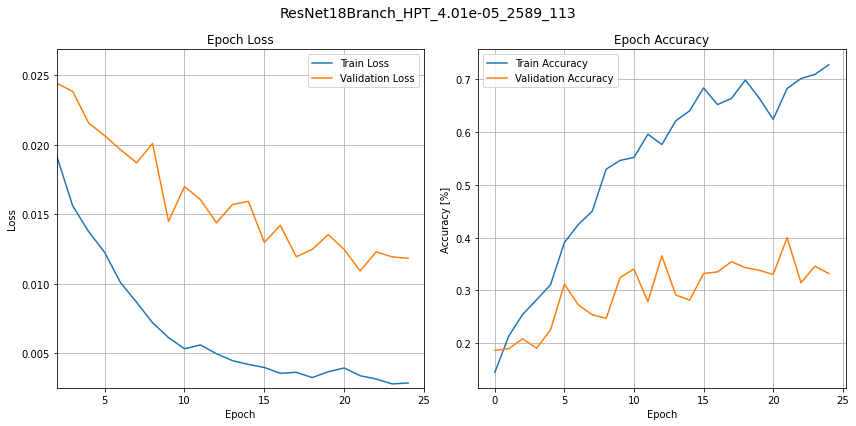



 Entrenamiento modelo: ResNet18Branch_HPT_1.21e-05_2630_701 


Epoch 1/25


Validation loss 0.02711: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0358 / 13.64% | Validation Loss / Accuracy: 0.0271 / 19.91%
Epoch 2/25


Validation loss 0.02547: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.21e-05_2630_701.pth
[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0271 / 19.81% | Validation Loss / Accuracy: 0.0255 / 22.77%
Epoch 3/25


Validation loss 0.02430: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.21e-05_2630_701.pth
[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0260 / 18.98% | Validation Loss / Accuracy: 0.0243 / 22.59%
Epoch 4/25


Validation loss 0.02342: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.21e-05_2630_701.pth
[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0216 / 19.35% | Validation Loss / Accuracy: 0.0234 / 22.14%
Epoch 5/25


Validation loss 0.02409: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0223 / 21.95% | Validation Loss / Accuracy: 0.0241 / 15.67%
Epoch 6/25


Validation loss 0.02475: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0203 / 23.26% | Validation Loss / Accuracy: 0.0247 / 20.98%
Epoch 7/25


Validation loss 0.02226: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.21e-05_2630_701.pth
[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0199 / 22.04% | Validation Loss / Accuracy: 0.0223 / 21.47%
Epoch 8/25


Validation loss 0.02481: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0184 / 25.91% | Validation Loss / Accuracy: 0.0248 / 14.69%
Epoch 9/25


Validation loss 0.02402: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0164 / 30.36% | Validation Loss / Accuracy: 0.0240 / 19.42%
Epoch 10/25


Validation loss 0.02091: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.21e-05_2630_701.pth
[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0157 / 28.28% | Validation Loss / Accuracy: 0.0209 / 24.91%
Epoch 11/25


Validation loss 0.02288: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0146 / 30.39% | Validation Loss / Accuracy: 0.0229 / 21.29%
Epoch 12/25


Validation loss 0.02158: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0141 / 30.43% | Validation Loss / Accuracy: 0.0216 / 25.09%
Epoch 13/25


Validation loss 0.02315: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0129 / 36.08% | Validation Loss / Accuracy: 0.0232 / 20.71%
Epoch 14/25


Validation loss 0.02096: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0122 / 34.58% | Validation Loss / Accuracy: 0.0210 / 24.64%
Epoch 15/25


Validation loss 0.01892: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.21e-05_2630_701.pth
[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0114 / 36.56% | Validation Loss / Accuracy: 0.0189 / 24.29%
Epoch 16/25


Validation loss 0.01940: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0105 / 40.24% | Validation Loss / Accuracy: 0.0194 / 24.11%
Epoch 17/25


Validation loss 0.01994: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0096 / 42.85% | Validation Loss / Accuracy: 0.0199 / 31.65%
Epoch 18/25


Validation loss 0.02370: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0092 / 42.99% | Validation Loss / Accuracy: 0.0237 / 20.00%
Epoch 19/25


Validation loss 0.02041: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0097 / 46.28% | Validation Loss / Accuracy: 0.0204 / 21.12%
Epoch 20/25


Validation loss 0.02034: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0094 / 46.66% | Validation Loss / Accuracy: 0.0203 / 28.84%
Epoch 21/25


Validation loss 0.01840: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.21e-05_2630_701.pth
[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0091 / 44.68% | Validation Loss / Accuracy: 0.0184 / 31.70%
Epoch 22/25


Validation loss 0.02120: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0080 / 45.21% | Validation Loss / Accuracy: 0.0212 / 25.36%
Epoch 23/25


Validation loss 0.02031: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0084 / 45.79% | Validation Loss / Accuracy: 0.0203 / 31.52%
Epoch 24/25


Validation loss 0.01921: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0078 / 50.27% | Validation Loss / Accuracy: 0.0192 / 31.70%
Epoch 25/25


Validation loss 0.01827: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.21e-05_2630_701.pth
[Lr:1.2136237983442418e-05] Training Loss / Accuracy: 0.0063 / 54.84% | Validation Loss / Accuracy: 0.0183 / 26.29%


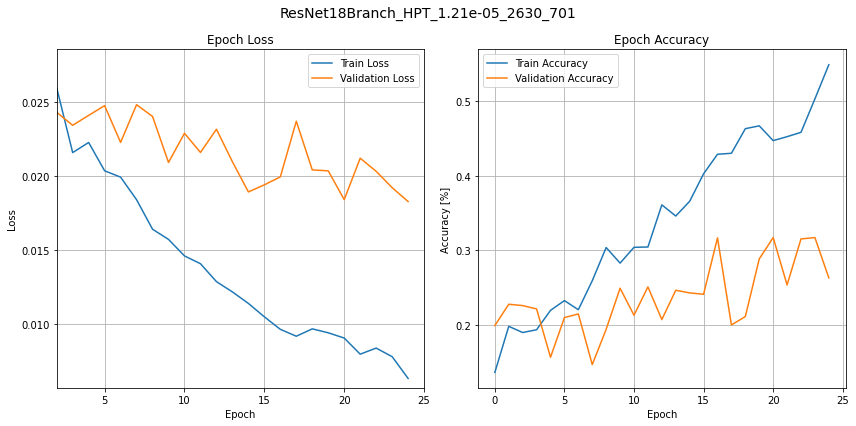



 Entrenamiento modelo: ResNet18Branch_HPT_1.88e-05_3158_874 


Epoch 1/25


Validation loss 0.02423: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0450 / 11.89% | Validation Loss / Accuracy: 0.0242 / 21.21%
Epoch 2/25


Validation loss 0.02674: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.88e-05_3158_874.pth
[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0271 / 20.72% | Validation Loss / Accuracy: 0.0267 / 19.96%
Epoch 3/25


Validation loss 0.02415: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.89s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.88e-05_3158_874.pth
[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0232 / 22.35% | Validation Loss / Accuracy: 0.0241 / 20.22%
Epoch 4/25


Validation loss 0.02374: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.88e-05_3158_874.pth
[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0197 / 26.59% | Validation Loss / Accuracy: 0.0237 / 21.52%
Epoch 5/25


Validation loss 0.02211: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.88e-05_3158_874.pth
[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0187 / 24.13% | Validation Loss / Accuracy: 0.0221 / 20.49%
Epoch 6/25


Validation loss 0.02356: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0162 / 30.68% | Validation Loss / Accuracy: 0.0236 / 22.10%
Epoch 7/25


Validation loss 0.02416: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0154 / 30.11% | Validation Loss / Accuracy: 0.0242 / 21.61%
Epoch 8/25


Validation loss 0.02119: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.88e-05_3158_874.pth
[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0132 / 33.89% | Validation Loss / Accuracy: 0.0212 / 25.27%
Epoch 9/25


Validation loss 0.01941: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.88e-05_3158_874.pth
[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0127 / 36.55% | Validation Loss / Accuracy: 0.0194 / 30.40%
Epoch 10/25


Validation loss 0.02081: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0115 / 41.24% | Validation Loss / Accuracy: 0.0208 / 27.28%
Epoch 11/25


Validation loss 0.01912: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.88e-05_3158_874.pth
[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0099 / 41.48% | Validation Loss / Accuracy: 0.0191 / 23.35%
Epoch 12/25


Validation loss 0.01890: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.88e-05_3158_874.pth
[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0087 / 45.78% | Validation Loss / Accuracy: 0.0189 / 26.47%
Epoch 13/25


Validation loss 0.01689: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.88e-05_3158_874.pth
[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0087 / 44.40% | Validation Loss / Accuracy: 0.0169 / 30.76%
Epoch 14/25


Validation loss 0.01726: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0077 / 49.61% | Validation Loss / Accuracy: 0.0173 / 28.26%
Epoch 15/25


Validation loss 0.01723: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0071 / 50.12% | Validation Loss / Accuracy: 0.0172 / 30.54%
Epoch 16/25


Validation loss 0.01701: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0074 / 50.03% | Validation Loss / Accuracy: 0.0170 / 32.63%
Epoch 17/25


Validation loss 0.01616: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.88e-05_3158_874.pth
[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0064 / 56.42% | Validation Loss / Accuracy: 0.0162 / 29.42%
Epoch 18/25


Validation loss 0.01654: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.89s/it]


[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0060 / 54.12% | Validation Loss / Accuracy: 0.0165 / 28.93%
Epoch 19/25


Validation loss 0.01615: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.88e-05_3158_874.pth
[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0059 / 55.62% | Validation Loss / Accuracy: 0.0162 / 24.60%
Epoch 20/25


Validation loss 0.01441: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.89s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.88e-05_3158_874.pth
[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0057 / 57.71% | Validation Loss / Accuracy: 0.0144 / 32.77%
Epoch 21/25


Validation loss 0.01569: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0059 / 53.45% | Validation Loss / Accuracy: 0.0157 / 29.91%
Epoch 22/25


Validation loss 0.01527: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0051 / 57.11% | Validation Loss / Accuracy: 0.0153 / 25.98%
Epoch 23/25


Validation loss 0.01492: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0055 / 60.17% | Validation Loss / Accuracy: 0.0149 / 33.39%
Epoch 24/25


Validation loss 0.01436: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.88e-05_3158_874.pth
[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0045 / 59.68% | Validation Loss / Accuracy: 0.0144 / 33.84%
Epoch 25/25


Validation loss 0.01606: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


[Lr:1.8805040551285834e-05] Training Loss / Accuracy: 0.0045 / 65.71% | Validation Loss / Accuracy: 0.0161 / 28.97%


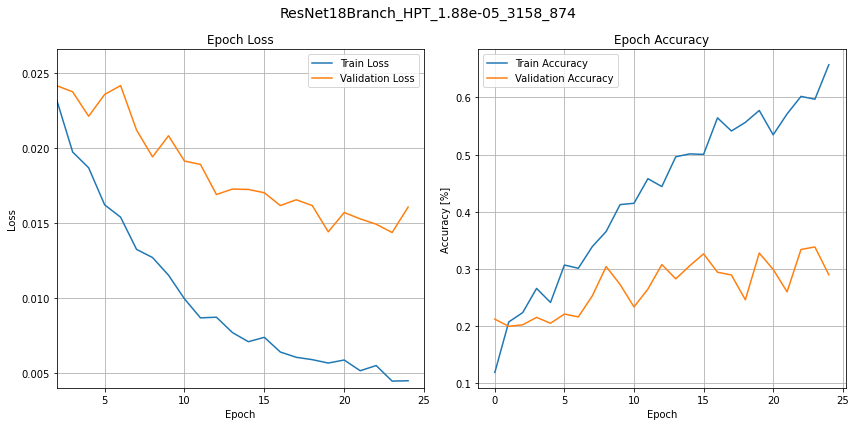



 Entrenamiento modelo: ResNet18Branch_HPT_5.02e-05_2209_56 


Epoch 1/25


Validation loss 0.02745: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0282 / 16.64% | Validation Loss / Accuracy: 0.0274 / 23.04%
Epoch 2/25


Validation loss 0.02383: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.81s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.02e-05_2209_56.pth
[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0214 / 18.97% | Validation Loss / Accuracy: 0.0238 / 25.00%
Epoch 3/25


Validation loss 0.02119: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.02e-05_2209_56.pth
[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0173 / 26.23% | Validation Loss / Accuracy: 0.0212 / 20.67%
Epoch 4/25


Validation loss 0.02153: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0140 / 32.48% | Validation Loss / Accuracy: 0.0215 / 21.88%
Epoch 5/25


Validation loss 0.01823: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.02e-05_2209_56.pth
[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0113 / 35.54% | Validation Loss / Accuracy: 0.0182 / 28.21%
Epoch 6/25


Validation loss 0.01835: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0101 / 40.28% | Validation Loss / Accuracy: 0.0183 / 32.81%
Epoch 7/25


Validation loss 0.01676: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.81s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.02e-05_2209_56.pth
[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0082 / 47.09% | Validation Loss / Accuracy: 0.0168 / 26.61%
Epoch 8/25


Validation loss 0.01831: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0070 / 49.16% | Validation Loss / Accuracy: 0.0183 / 24.11%
Epoch 9/25


Validation loss 0.01731: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0061 / 52.09% | Validation Loss / Accuracy: 0.0173 / 29.02%
Epoch 10/25


Validation loss 0.01559: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.02e-05_2209_56.pth
[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0053 / 56.61% | Validation Loss / Accuracy: 0.0156 / 34.20%
Epoch 11/25


Validation loss 0.01485: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.02e-05_2209_56.pth
[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0050 / 58.34% | Validation Loss / Accuracy: 0.0149 / 29.46%
Epoch 12/25


Validation loss 0.01427: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.02e-05_2209_56.pth
[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0045 / 62.93% | Validation Loss / Accuracy: 0.0143 / 28.53%
Epoch 13/25


Validation loss 0.01508: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0041 / 62.55% | Validation Loss / Accuracy: 0.0151 / 37.50%
Epoch 14/25


Validation loss 0.01387: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.02e-05_2209_56.pth
[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0038 / 64.66% | Validation Loss / Accuracy: 0.0139 / 25.54%
Epoch 15/25


Validation loss 0.01397: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0037 / 66.98% | Validation Loss / Accuracy: 0.0140 / 31.38%
Epoch 16/25


Validation loss 0.01301: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.02e-05_2209_56.pth
[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0032 / 71.78% | Validation Loss / Accuracy: 0.0130 / 36.56%
Epoch 17/25


Validation loss 0.01380: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0034 / 68.19% | Validation Loss / Accuracy: 0.0138 / 34.46%
Epoch 18/25


Validation loss 0.01338: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0033 / 72.60% | Validation Loss / Accuracy: 0.0134 / 31.16%
Epoch 19/25


Validation loss 0.01315: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0029 / 72.52% | Validation Loss / Accuracy: 0.0131 / 36.12%
Epoch 20/25


Validation loss 0.01277: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.02e-05_2209_56.pth
[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0029 / 71.37% | Validation Loss / Accuracy: 0.0128 / 32.28%
Epoch 21/25


Validation loss 0.01238: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.02e-05_2209_56.pth
[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0027 / 75.43% | Validation Loss / Accuracy: 0.0124 / 32.59%
Epoch 22/25


Validation loss 0.01082: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.02e-05_2209_56.pth
[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0024 / 75.97% | Validation Loss / Accuracy: 0.0108 / 36.07%
Epoch 23/25


Validation loss 0.01205: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0025 / 76.53% | Validation Loss / Accuracy: 0.0121 / 31.65%
Epoch 24/25


Validation loss 0.01090: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0026 / 74.71% | Validation Loss / Accuracy: 0.0109 / 35.76%
Epoch 25/25


Validation loss 0.00993: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.02e-05_2209_56.pth
[Lr:5.0199651331100794e-05] Training Loss / Accuracy: 0.0025 / 75.32% | Validation Loss / Accuracy: 0.0099 / 38.88%


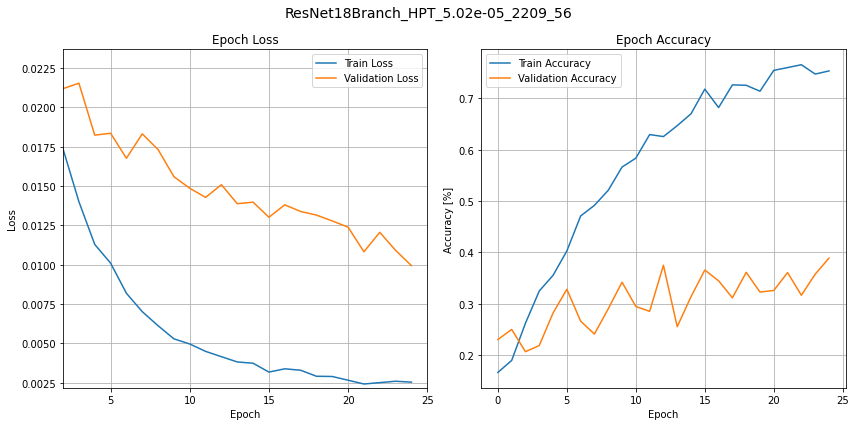



 Entrenamiento modelo: ResNet18Branch_HPT_5.09e-05_1612_468 


Epoch 1/25


Validation loss 0.03482: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0353 / 14.18% | Validation Loss / Accuracy: 0.0348 / 15.36%
Epoch 2/25


Validation loss 0.02524: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.09e-05_1612_468.pth
[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0233 / 21.71% | Validation Loss / Accuracy: 0.0252 / 17.68%
Epoch 3/25


Validation loss 0.02282: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.09e-05_1612_468.pth
[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0176 / 27.11% | Validation Loss / Accuracy: 0.0228 / 22.28%
Epoch 4/25


Validation loss 0.02246: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.92s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.09e-05_1612_468.pth
[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0159 / 29.46% | Validation Loss / Accuracy: 0.0225 / 21.92%
Epoch 5/25


Validation loss 0.02141: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.09e-05_1612_468.pth
[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0122 / 35.28% | Validation Loss / Accuracy: 0.0214 / 26.96%
Epoch 6/25


Validation loss 0.01743: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.09e-05_1612_468.pth
[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0104 / 43.32% | Validation Loss / Accuracy: 0.0174 / 30.45%
Epoch 7/25


Validation loss 0.01883: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0100 / 40.86% | Validation Loss / Accuracy: 0.0188 / 30.89%
Epoch 8/25


Validation loss 0.01916: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0077 / 46.56% | Validation Loss / Accuracy: 0.0192 / 25.85%
Epoch 9/25


Validation loss 0.01691: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.09e-05_1612_468.pth
[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0066 / 52.07% | Validation Loss / Accuracy: 0.0169 / 26.47%
Epoch 10/25


Validation loss 0.01711: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0056 / 55.52% | Validation Loss / Accuracy: 0.0171 / 30.09%
Epoch 11/25


Validation loss 0.01501: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.09e-05_1612_468.pth
[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0053 / 55.67% | Validation Loss / Accuracy: 0.0150 / 32.95%
Epoch 12/25


Validation loss 0.01398: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.09e-05_1612_468.pth
[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0049 / 59.13% | Validation Loss / Accuracy: 0.0140 / 34.96%
Epoch 13/25


Validation loss 0.01434: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0047 / 61.72% | Validation Loss / Accuracy: 0.0143 / 29.73%
Epoch 14/25


Validation loss 0.01455: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0047 / 61.19% | Validation Loss / Accuracy: 0.0146 / 31.96%
Epoch 15/25


Validation loss 0.01588: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0040 / 66.68% | Validation Loss / Accuracy: 0.0159 / 32.01%
Epoch 16/25


Validation loss 0.01391: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.09e-05_1612_468.pth
[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0046 / 60.77% | Validation Loss / Accuracy: 0.0139 / 34.20%
Epoch 17/25


Validation loss 0.01288: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.91s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.09e-05_1612_468.pth
[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0039 / 66.27% | Validation Loss / Accuracy: 0.0129 / 31.61%
Epoch 18/25


Validation loss 0.01242: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.09e-05_1612_468.pth
[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0035 / 67.11% | Validation Loss / Accuracy: 0.0124 / 40.80%
Epoch 19/25


Validation loss 0.01286: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0036 / 68.76% | Validation Loss / Accuracy: 0.0129 / 38.26%
Epoch 20/25


Validation loss 0.01289: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0031 / 71.16% | Validation Loss / Accuracy: 0.0129 / 33.21%
Epoch 21/25


Validation loss 0.01270: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0029 / 69.51% | Validation Loss / Accuracy: 0.0127 / 32.23%
Epoch 22/25


Validation loss 0.01294: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0029 / 73.32% | Validation Loss / Accuracy: 0.0129 / 37.05%
Epoch 23/25


Validation loss 0.01152: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.09e-05_1612_468.pth
[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0031 / 70.38% | Validation Loss / Accuracy: 0.0115 / 34.02%
Epoch 24/25


Validation loss 0.01136: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_5.09e-05_1612_468.pth
[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0032 / 71.07% | Validation Loss / Accuracy: 0.0114 / 32.41%
Epoch 25/25


Validation loss 0.01210: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:5.089870193519685e-05] Training Loss / Accuracy: 0.0029 / 71.09% | Validation Loss / Accuracy: 0.0121 / 36.07%


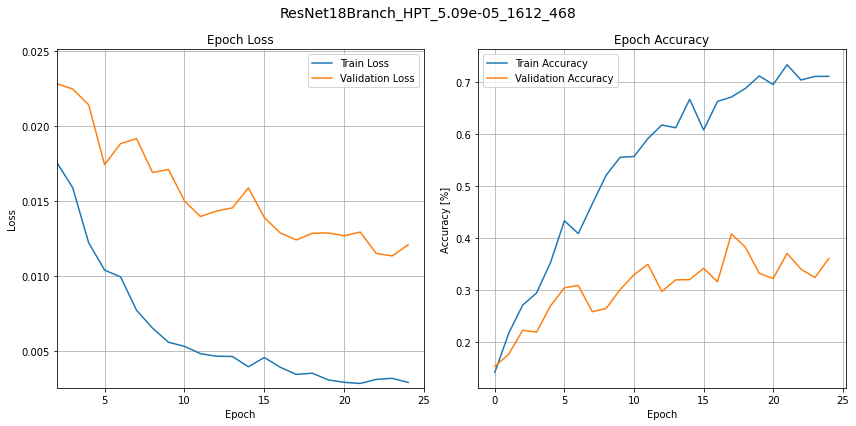



 Entrenamiento modelo: ResNet18Branch_HPT_8.30e-05_3332_130 


Epoch 1/25


Validation loss 0.02669: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0395 / 18.85% | Validation Loss / Accuracy: 0.0267 / 20.71%
Epoch 2/25


Validation loss 0.02352: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_8.30e-05_3332_130.pth
[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0229 / 19.82% | Validation Loss / Accuracy: 0.0235 / 19.73%
Epoch 3/25


Validation loss 0.02086: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_8.30e-05_3332_130.pth
[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0191 / 22.19% | Validation Loss / Accuracy: 0.0209 / 22.90%
Epoch 4/25


Validation loss 0.01915: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_8.30e-05_3332_130.pth
[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0147 / 26.53% | Validation Loss / Accuracy: 0.0191 / 24.60%
Epoch 5/25


Validation loss 0.01911: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_8.30e-05_3332_130.pth
[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0108 / 37.98% | Validation Loss / Accuracy: 0.0191 / 21.12%
Epoch 6/25


Validation loss 0.01552: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_8.30e-05_3332_130.pth
[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0092 / 43.85% | Validation Loss / Accuracy: 0.0155 / 30.27%
Epoch 7/25


Validation loss 0.01494: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_8.30e-05_3332_130.pth
[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0073 / 45.13% | Validation Loss / Accuracy: 0.0149 / 32.14%
Epoch 8/25


Validation loss 0.01505: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0061 / 55.91% | Validation Loss / Accuracy: 0.0150 / 36.43%
Epoch 9/25


Validation loss 0.01395: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_8.30e-05_3332_130.pth
[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0049 / 57.49% | Validation Loss / Accuracy: 0.0140 / 33.39%
Epoch 10/25


Validation loss 0.01278: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_8.30e-05_3332_130.pth
[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0042 / 65.66% | Validation Loss / Accuracy: 0.0128 / 33.53%
Epoch 11/25


Validation loss 0.01294: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0035 / 68.64% | Validation Loss / Accuracy: 0.0129 / 39.20%
Epoch 12/25


Validation loss 0.01245: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_8.30e-05_3332_130.pth
[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0038 / 66.86% | Validation Loss / Accuracy: 0.0124 / 32.41%
Epoch 13/25


Validation loss 0.01261: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0033 / 74.10% | Validation Loss / Accuracy: 0.0126 / 35.80%
Epoch 14/25


Validation loss 0.01031: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_8.30e-05_3332_130.pth
[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0035 / 66.48% | Validation Loss / Accuracy: 0.0103 / 36.96%
Epoch 15/25


Validation loss 0.01017: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_8.30e-05_3332_130.pth
[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0029 / 76.15% | Validation Loss / Accuracy: 0.0102 / 44.73%
Epoch 16/25


Validation loss 0.01093: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0030 / 70.45% | Validation Loss / Accuracy: 0.0109 / 35.71%
Epoch 17/25


Validation loss 0.00985: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_8.30e-05_3332_130.pth
[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0030 / 69.59% | Validation Loss / Accuracy: 0.0098 / 45.49%
Epoch 18/25


Validation loss 0.01061: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.81s/it]


[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0024 / 75.06% | Validation Loss / Accuracy: 0.0106 / 37.41%
Epoch 19/25


Validation loss 0.01127: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0028 / 71.77% | Validation Loss / Accuracy: 0.0113 / 40.89%
Epoch 20/25


Validation loss 0.00980: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_8.30e-05_3332_130.pth
[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0023 / 79.24% | Validation Loss / Accuracy: 0.0098 / 36.65%
Epoch 21/25


Validation loss 0.00982: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0021 / 78.77% | Validation Loss / Accuracy: 0.0098 / 43.48%
Epoch 22/25


Validation loss 0.01134: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0020 / 80.72% | Validation Loss / Accuracy: 0.0113 / 45.58%
Epoch 23/25


Validation loss 0.01016: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0018 / 81.17% | Validation Loss / Accuracy: 0.0102 / 44.69%
Epoch 24/25


Validation loss 0.01087: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0019 / 81.52% | Validation Loss / Accuracy: 0.0109 / 38.48%
Epoch 25/25


Validation loss 0.00930: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_8.30e-05_3332_130.pth
[Lr:8.296958520834916e-05] Training Loss / Accuracy: 0.0021 / 79.11% | Validation Loss / Accuracy: 0.0093 / 43.53%


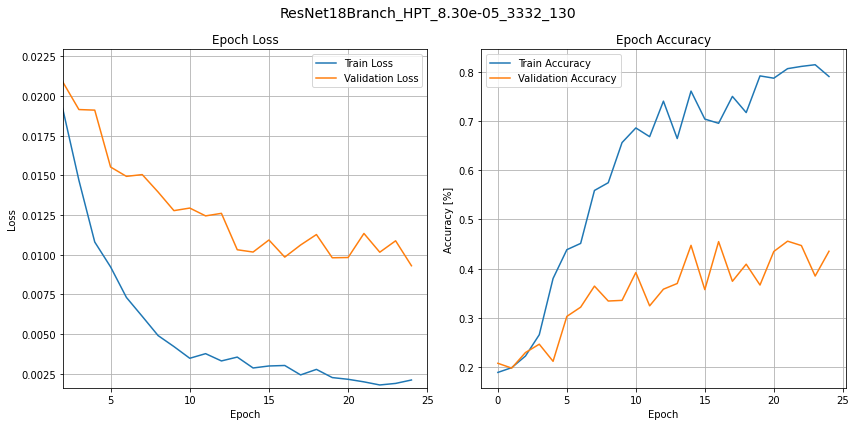



 Entrenamiento modelo: ResNet18Branch_HPT_3.99e-05_1971_635 


Epoch 1/25


Validation loss 0.02234: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0295 / 18.94% | Validation Loss / Accuracy: 0.0223 / 23.88%
Epoch 2/25


Validation loss 0.02474: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_3.99e-05_1971_635.pth
[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0217 / 20.90% | Validation Loss / Accuracy: 0.0247 / 18.17%
Epoch 3/25


Validation loss 0.02514: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0183 / 24.00% | Validation Loss / Accuracy: 0.0251 / 20.49%
Epoch 4/25


Validation loss 0.01979: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_3.99e-05_1971_635.pth
[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0149 / 31.52% | Validation Loss / Accuracy: 0.0198 / 25.76%
Epoch 5/25


Validation loss 0.02186: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0126 / 36.52% | Validation Loss / Accuracy: 0.0219 / 24.29%
Epoch 6/25


Validation loss 0.01986: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0110 / 40.23% | Validation Loss / Accuracy: 0.0199 / 25.80%
Epoch 7/25


Validation loss 0.01892: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_3.99e-05_1971_635.pth
[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0090 / 46.12% | Validation Loss / Accuracy: 0.0189 / 32.63%
Epoch 8/25


Validation loss 0.01936: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.91s/it]


[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0081 / 47.50% | Validation Loss / Accuracy: 0.0194 / 26.03%
Epoch 9/25


Validation loss 0.01840: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_3.99e-05_1971_635.pth
[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0074 / 46.69% | Validation Loss / Accuracy: 0.0184 / 28.57%
Epoch 10/25


Validation loss 0.01901: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0068 / 53.17% | Validation Loss / Accuracy: 0.0190 / 28.84%
Epoch 11/25


Validation loss 0.01745: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.89s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_3.99e-05_1971_635.pth
[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0064 / 54.38% | Validation Loss / Accuracy: 0.0175 / 27.10%
Epoch 12/25


Validation loss 0.01613: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_3.99e-05_1971_635.pth
[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0064 / 54.13% | Validation Loss / Accuracy: 0.0161 / 32.28%
Epoch 13/25


Validation loss 0.01713: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0063 / 52.29% | Validation Loss / Accuracy: 0.0171 / 30.89%
Epoch 14/25


Validation loss 0.01660: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0051 / 60.68% | Validation Loss / Accuracy: 0.0166 / 31.65%
Epoch 15/25


Validation loss 0.01822: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0047 / 61.44% | Validation Loss / Accuracy: 0.0182 / 26.79%
Epoch 16/25


Validation loss 0.01624: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0048 / 59.05% | Validation Loss / Accuracy: 0.0162 / 30.94%
Epoch 17/25


Validation loss 0.01633: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.89s/it]


[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0049 / 59.07% | Validation Loss / Accuracy: 0.0163 / 25.98%
Epoch 18/25


Validation loss 0.01479: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_3.99e-05_1971_635.pth
[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0042 / 58.75% | Validation Loss / Accuracy: 0.0148 / 28.17%
Epoch 19/25


Validation loss 0.01397: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_3.99e-05_1971_635.pth
[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0049 / 59.45% | Validation Loss / Accuracy: 0.0140 / 35.40%
Epoch 20/25


Validation loss 0.01888: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0039 / 65.40% | Validation Loss / Accuracy: 0.0189 / 28.17%
Epoch 21/25


Validation loss 0.01478: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0046 / 61.38% | Validation Loss / Accuracy: 0.0148 / 32.28%
Epoch 22/25


Validation loss 0.01309: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.96s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_3.99e-05_1971_635.pth
[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0034 / 66.94% | Validation Loss / Accuracy: 0.0131 / 35.00%
Epoch 23/25


Validation loss 0.01381: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0031 / 70.32% | Validation Loss / Accuracy: 0.0138 / 32.77%
Epoch 24/25


Validation loss 0.01330: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.89s/it]


[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0030 / 69.59% | Validation Loss / Accuracy: 0.0133 / 30.13%
Epoch 25/25


Validation loss 0.01541: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:3.986581073580439e-05] Training Loss / Accuracy: 0.0036 / 65.33% | Validation Loss / Accuracy: 0.0154 / 28.97%


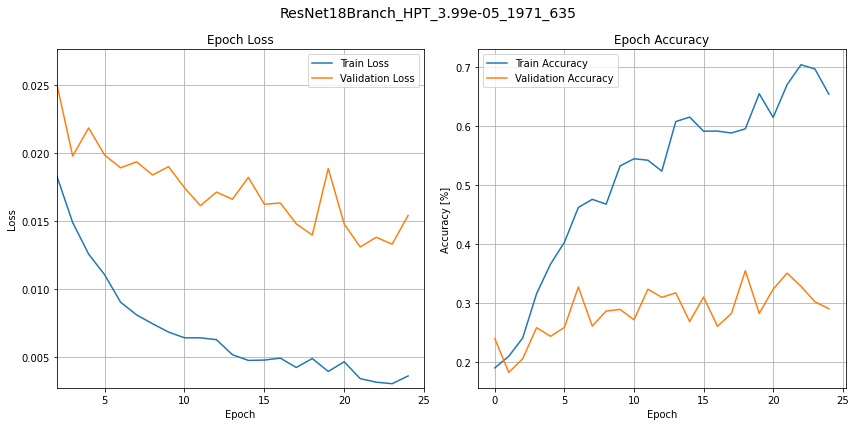



 Entrenamiento modelo: ResNet18Branch_HPT_2.35e-05_1254_967 


Epoch 1/25


Validation loss 0.02898: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


[Lr:2.3462288481422625e-05] Training Loss / Accuracy: 0.0310 / 19.76% | Validation Loss / Accuracy: 0.0290 / 15.31%
Epoch 2/25


Validation loss 0.02396: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_2.35e-05_1254_967.pth
[Lr:2.3462288481422625e-05] Training Loss / Accuracy: 0.0246 / 20.59% | Validation Loss / Accuracy: 0.0240 / 18.79%
Epoch 3/25


Validation loss 0.02095: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_2.35e-05_1254_967.pth
[Lr:2.3462288481422625e-05] Training Loss / Accuracy: 0.0222 / 18.98% | Validation Loss / Accuracy: 0.0209 / 22.14%
Epoch 4/25


Validation loss 0.02148: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:2.3462288481422625e-05] Training Loss / Accuracy: 0.0192 / 23.89% | Validation Loss / Accuracy: 0.0215 / 22.59%
Epoch 5/25


Validation loss 0.02039: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_2.35e-05_1254_967.pth
[Lr:2.3462288481422625e-05] Training Loss / Accuracy: 0.0182 / 25.53% | Validation Loss / Accuracy: 0.0204 / 22.59%
Epoch 6/25


Validation loss 0.02218: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


[Lr:2.3462288481422625e-05] Training Loss / Accuracy: 0.0160 / 29.84% | Validation Loss / Accuracy: 0.0222 / 17.99%
Epoch 7/25


Validation loss 0.02025: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_2.35e-05_1254_967.pth
[Lr:2.3462288481422625e-05] Training Loss / Accuracy: 0.0143 / 32.00% | Validation Loss / Accuracy: 0.0202 / 17.37%
Epoch 8/25


Validation loss 0.01781: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_2.35e-05_1254_967.pth
[Lr:2.3462288481422625e-05] Training Loss / Accuracy: 0.0132 / 32.09% | Validation Loss / Accuracy: 0.0178 / 26.07%
Epoch 9/25


Validation loss 0.01887: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:2.3462288481422625e-05] Training Loss / Accuracy: 0.0114 / 38.18% | Validation Loss / Accuracy: 0.0189 / 28.26%
Epoch 10/25


Validation loss 0.02119: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:2.3462288481422625e-05] Training Loss / Accuracy: 0.0113 / 41.23% | Validation Loss / Accuracy: 0.0212 / 28.04%
Epoch 11/25


Validation loss 0.01891: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:2.3462288481422625e-05] Training Loss / Accuracy: 0.0094 / 43.82% | Validation Loss / Accuracy: 0.0189 / 24.11%
Epoch 12/25


Validation loss 0.01925: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:2.3462288481422625e-05] Training Loss / Accuracy: 0.0091 / 44.61% | Validation Loss / Accuracy: 0.0193 / 29.51%
Epoch 13/25


Validation loss 0.02008: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:2.3462288481422625e-05] Training Loss / Accuracy: 0.0079 / 49.52% | Validation Loss / Accuracy: 0.0201 / 28.21%
Epoch 14/25


Validation loss 0.01950: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


Se interrumpió el entrenamiento porque en los últimos 6 epochs no se logró menor loss que el mínimo (min:0.01781217185780406)


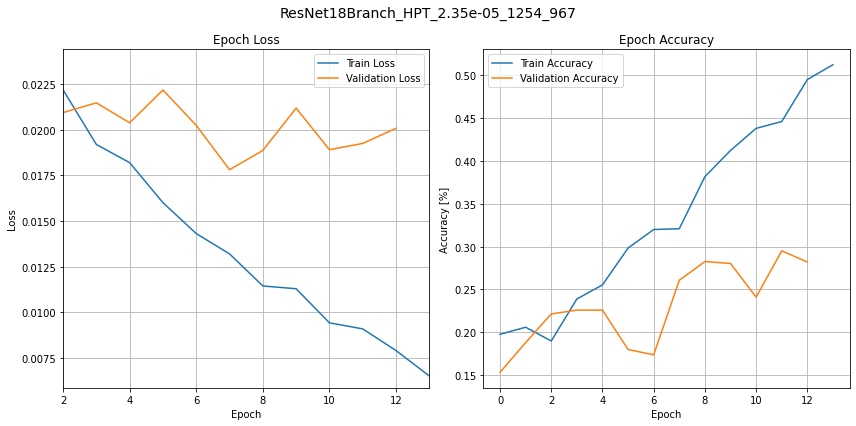



 Entrenamiento modelo: ResNet18Branch_HPT_1.68e-04_3115_453 


Epoch 1/25


Validation loss 0.03878: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0813 / 18.20% | Validation Loss / Accuracy: 0.0388 / 12.54%
Epoch 2/25


Validation loss 0.02505: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.91s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.68e-04_3115_453.pth
[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0260 / 20.47% | Validation Loss / Accuracy: 0.0251 / 21.29%
Epoch 3/25


Validation loss 0.02370: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.68e-04_3115_453.pth
[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0182 / 24.84% | Validation Loss / Accuracy: 0.0237 / 22.72%
Epoch 4/25


Validation loss 0.01600: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.68e-04_3115_453.pth
[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0114 / 36.40% | Validation Loss / Accuracy: 0.0160 / 32.63%
Epoch 5/25


Validation loss 0.01353: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.68e-04_3115_453.pth
[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0082 / 43.17% | Validation Loss / Accuracy: 0.0135 / 34.78%
Epoch 6/25


Validation loss 0.01370: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0063 / 52.59% | Validation Loss / Accuracy: 0.0137 / 32.28%
Epoch 7/25


Validation loss 0.01004: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.68e-04_3115_453.pth
[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0051 / 59.76% | Validation Loss / Accuracy: 0.0100 / 39.82%
Epoch 8/25


Validation loss 0.01050: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0036 / 66.81% | Validation Loss / Accuracy: 0.0105 / 44.02%
Epoch 9/25


Validation loss 0.01051: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0030 / 71.04% | Validation Loss / Accuracy: 0.0105 / 40.40%
Epoch 10/25


Validation loss 0.00819: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.68e-04_3115_453.pth
[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0031 / 68.47% | Validation Loss / Accuracy: 0.0082 / 44.69%
Epoch 11/25


Validation loss 0.00882: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0026 / 70.60% | Validation Loss / Accuracy: 0.0088 / 43.57%
Epoch 12/25


Validation loss 0.00824: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0022 / 76.28% | Validation Loss / Accuracy: 0.0082 / 48.44%
Epoch 13/25


Validation loss 0.00824: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.89s/it]


[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0023 / 76.53% | Validation Loss / Accuracy: 0.0082 / 45.13%
Epoch 14/25


Validation loss 0.00841: 100%|███████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.10s/it]


[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0020 / 79.53% | Validation Loss / Accuracy: 0.0084 / 46.56%
Epoch 15/25


Validation loss 0.00777: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.68e-04_3115_453.pth
[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0019 / 80.97% | Validation Loss / Accuracy: 0.0078 / 44.33%
Epoch 16/25


Validation loss 0.00736: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.68e-04_3115_453.pth
[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0018 / 81.12% | Validation Loss / Accuracy: 0.0074 / 48.57%
Epoch 17/25


Validation loss 0.00699: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.68e-04_3115_453.pth
[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0017 / 84.36% | Validation Loss / Accuracy: 0.0070 / 48.44%
Epoch 18/25


Validation loss 0.00728: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0017 / 80.71% | Validation Loss / Accuracy: 0.0073 / 46.43%
Epoch 19/25


Validation loss 0.00728: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0016 / 83.23% | Validation Loss / Accuracy: 0.0073 / 54.11%
Epoch 20/25


Validation loss 0.00692: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.68e-04_3115_453.pth
[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0014 / 84.40% | Validation Loss / Accuracy: 0.0069 / 49.55%
Epoch 21/25


Validation loss 0.00711: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0015 / 83.62% | Validation Loss / Accuracy: 0.0071 / 49.69%
Epoch 22/25


Validation loss 0.00655: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.68e-04_3115_453.pth
[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0017 / 83.50% | Validation Loss / Accuracy: 0.0065 / 57.72%
Epoch 23/25


Validation loss 0.00695: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0014 / 85.99% | Validation Loss / Accuracy: 0.0070 / 49.02%
Epoch 24/25


Validation loss 0.00724: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0017 / 82.55% | Validation Loss / Accuracy: 0.0072 / 49.60%
Epoch 25/25


Validation loss 0.00759: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:0.00016796748720926532] Training Loss / Accuracy: 0.0017 / 78.63% | Validation Loss / Accuracy: 0.0076 / 43.39%


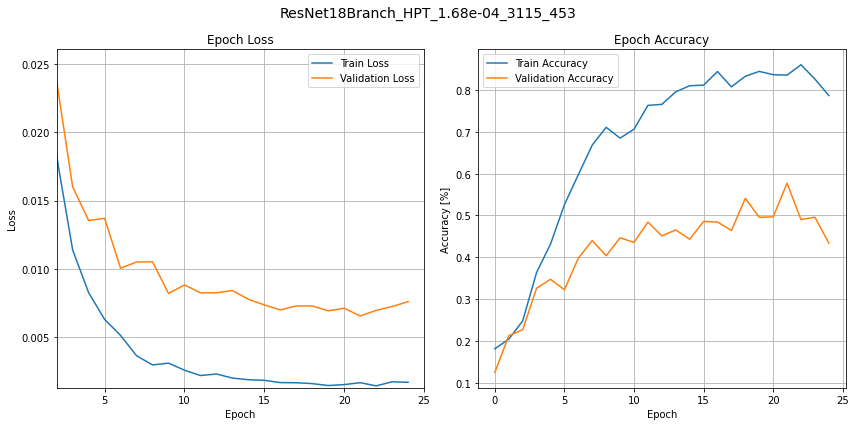



 Entrenamiento modelo: ResNet18Branch_HPT_1.23e-04_691_839 


Epoch 1/25


Validation loss 0.02577: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0321 / 17.70% | Validation Loss / Accuracy: 0.0258 / 24.02%
Epoch 2/25


Validation loss 0.02300: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.23e-04_691_839.pth
[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0192 / 25.52% | Validation Loss / Accuracy: 0.0230 / 18.66%
Epoch 3/25


Validation loss 0.01902: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.23e-04_691_839.pth
[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0148 / 32.80% | Validation Loss / Accuracy: 0.0190 / 28.39%
Epoch 4/25


Validation loss 0.01874: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.23e-04_691_839.pth
[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0110 / 37.89% | Validation Loss / Accuracy: 0.0187 / 28.35%
Epoch 5/25


Validation loss 0.01528: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.23e-04_691_839.pth
[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0080 / 47.66% | Validation Loss / Accuracy: 0.0153 / 28.35%
Epoch 6/25


Validation loss 0.01444: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.23e-04_691_839.pth
[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0068 / 52.66% | Validation Loss / Accuracy: 0.0144 / 30.71%
Epoch 7/25


Validation loss 0.01726: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0053 / 58.68% | Validation Loss / Accuracy: 0.0173 / 29.15%
Epoch 8/25


Validation loss 0.01344: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.23e-04_691_839.pth
[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0052 / 60.61% | Validation Loss / Accuracy: 0.0134 / 35.13%
Epoch 9/25


Validation loss 0.01169: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.23e-04_691_839.pth
[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0040 / 64.31% | Validation Loss / Accuracy: 0.0117 / 37.32%
Epoch 10/25


Validation loss 0.01078: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.23e-04_691_839.pth
[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0035 / 68.94% | Validation Loss / Accuracy: 0.0108 / 37.28%
Epoch 11/25


Validation loss 0.01060: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.92s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.23e-04_691_839.pth
[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0034 / 67.95% | Validation Loss / Accuracy: 0.0106 / 42.50%
Epoch 12/25


Validation loss 0.01121: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0028 / 70.01% | Validation Loss / Accuracy: 0.0112 / 38.88%
Epoch 13/25


Validation loss 0.00957: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.23e-04_691_839.pth
[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0026 / 75.54% | Validation Loss / Accuracy: 0.0096 / 46.96%
Epoch 14/25


Validation loss 0.00962: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0029 / 74.18% | Validation Loss / Accuracy: 0.0096 / 38.57%
Epoch 15/25


Validation loss 0.01117: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0026 / 73.44% | Validation Loss / Accuracy: 0.0112 / 43.26%
Epoch 16/25


Validation loss 0.01001: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0024 / 74.62% | Validation Loss / Accuracy: 0.0100 / 42.28%
Epoch 17/25


Validation loss 0.00935: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.23e-04_691_839.pth
[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0024 / 78.08% | Validation Loss / Accuracy: 0.0093 / 45.18%
Epoch 18/25


Validation loss 0.00880: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.23e-04_691_839.pth
[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0021 / 80.31% | Validation Loss / Accuracy: 0.0088 / 44.37%
Epoch 19/25


Validation loss 0.00944: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0021 / 76.50% | Validation Loss / Accuracy: 0.0094 / 38.53%
Epoch 20/25


Validation loss 0.00910: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0025 / 75.03% | Validation Loss / Accuracy: 0.0091 / 43.88%
Epoch 21/25


Validation loss 0.01076: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0021 / 79.40% | Validation Loss / Accuracy: 0.0108 / 39.46%
Epoch 22/25


Validation loss 0.00985: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.89s/it]


[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0022 / 76.27% | Validation Loss / Accuracy: 0.0099 / 39.11%
Epoch 23/25


Validation loss 0.00971: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:0.0001233363497913776] Training Loss / Accuracy: 0.0018 / 82.84% | Validation Loss / Accuracy: 0.0097 / 38.08%
Epoch 24/25


Validation loss 0.00904: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


Se interrumpió el entrenamiento porque en los últimos 6 epochs no se logró menor loss que el mínimo (min:0.008803065959364175)


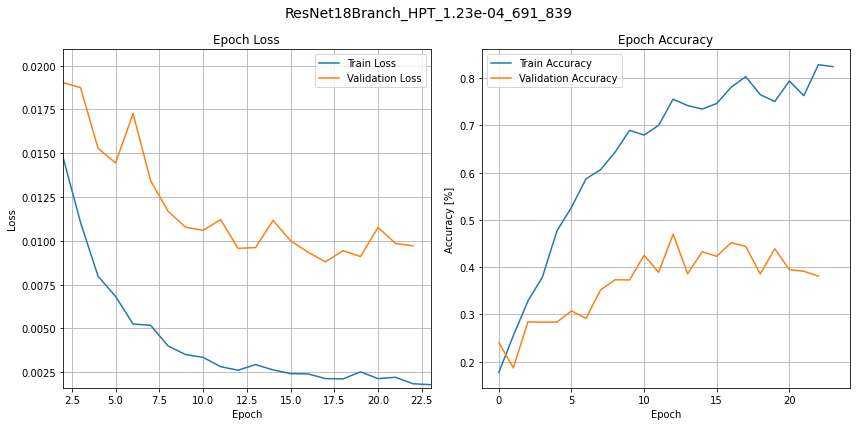



 Entrenamiento modelo: ResNet18Branch_HPT_1.02e-05_3798_878 


Epoch 1/25


Validation loss 0.02462: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0339 / 17.26% | Validation Loss / Accuracy: 0.0246 / 21.96%
Epoch 2/25


Validation loss 0.02400: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.02e-05_3798_878.pth
[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0268 / 19.95% | Validation Loss / Accuracy: 0.0240 / 21.79%
Epoch 3/25


Validation loss 0.02383: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.02e-05_3798_878.pth
[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0246 / 17.88% | Validation Loss / Accuracy: 0.0238 / 20.89%
Epoch 4/25


Validation loss 0.02475: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0230 / 22.88% | Validation Loss / Accuracy: 0.0248 / 17.19%
Epoch 5/25


Validation loss 0.02368: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.02e-05_3798_878.pth
[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0221 / 19.44% | Validation Loss / Accuracy: 0.0237 / 20.67%
Epoch 6/25


Validation loss 0.02417: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0210 / 22.41% | Validation Loss / Accuracy: 0.0242 / 18.97%
Epoch 7/25


Validation loss 0.02211: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.02e-05_3798_878.pth
[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0191 / 22.78% | Validation Loss / Accuracy: 0.0221 / 19.73%
Epoch 8/25


Validation loss 0.02421: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.91s/it]


[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0181 / 27.75% | Validation Loss / Accuracy: 0.0242 / 18.44%
Epoch 9/25


Validation loss 0.02100: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.02e-05_3798_878.pth
[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0168 / 25.83% | Validation Loss / Accuracy: 0.0210 / 24.73%
Epoch 10/25


Validation loss 0.02155: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0149 / 27.49% | Validation Loss / Accuracy: 0.0215 / 21.12%
Epoch 11/25


Validation loss 0.02013: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.02e-05_3798_878.pth
[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0154 / 29.46% | Validation Loss / Accuracy: 0.0201 / 32.05%
Epoch 12/25


Validation loss 0.02638: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0137 / 32.74% | Validation Loss / Accuracy: 0.0264 / 23.93%
Epoch 13/25


Validation loss 0.02071: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.89s/it]


[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0133 / 33.34% | Validation Loss / Accuracy: 0.0207 / 23.79%
Epoch 14/25


Validation loss 0.02126: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0129 / 30.49% | Validation Loss / Accuracy: 0.0213 / 20.94%
Epoch 15/25


Validation loss 0.02194: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0126 / 39.14% | Validation Loss / Accuracy: 0.0219 / 23.75%
Epoch 16/25


Validation loss 0.02128: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0114 / 38.01% | Validation Loss / Accuracy: 0.0213 / 21.56%
Epoch 17/25


Validation loss 0.01990: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.02e-05_3798_878.pth
[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0099 / 39.83% | Validation Loss / Accuracy: 0.0199 / 27.46%
Epoch 18/25


Validation loss 0.01986: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.02e-05_3798_878.pth
[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0104 / 41.36% | Validation Loss / Accuracy: 0.0199 / 24.60%
Epoch 19/25


Validation loss 0.02157: 100%|███████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.01s/it]


[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0096 / 44.32% | Validation Loss / Accuracy: 0.0216 / 28.97%
Epoch 20/25


Validation loss 0.02158: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0087 / 44.74% | Validation Loss / Accuracy: 0.0216 / 23.97%
Epoch 21/25


Validation loss 0.02114: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.89s/it]


[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0084 / 45.98% | Validation Loss / Accuracy: 0.0211 / 29.29%
Epoch 22/25


Validation loss 0.02100: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0079 / 48.88% | Validation Loss / Accuracy: 0.0210 / 29.82%
Epoch 23/25


Validation loss 0.01798: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.02e-05_3798_878.pth
[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0084 / 47.70% | Validation Loss / Accuracy: 0.0180 / 31.21%
Epoch 24/25


Validation loss 0.02022: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.89s/it]


[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0082 / 50.34% | Validation Loss / Accuracy: 0.0202 / 21.29%
Epoch 25/25


Validation loss 0.02055: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


[Lr:1.0233165783302449e-05] Training Loss / Accuracy: 0.0079 / 50.85% | Validation Loss / Accuracy: 0.0205 / 24.91%


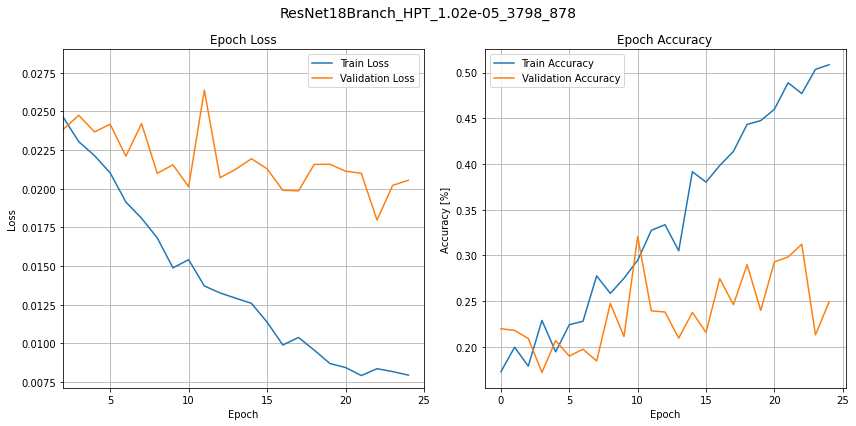



 Entrenamiento modelo: ResNet18Branch_HPT_7.94e-04_472_443 


Epoch 1/25


Validation loss 0.03026: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.96s/it]


[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0809 / 10.69% | Validation Loss / Accuracy: 0.0303 / 18.35%
Epoch 2/25


Validation loss 0.02419: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.94e-04_472_443.pth
[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0226 / 21.71% | Validation Loss / Accuracy: 0.0242 / 20.04%
Epoch 3/25


Validation loss 0.02161: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.94e-04_472_443.pth
[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0195 / 29.57% | Validation Loss / Accuracy: 0.0216 / 21.16%
Epoch 4/25


Validation loss 0.02125: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.94e-04_472_443.pth
[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0172 / 28.56% | Validation Loss / Accuracy: 0.0213 / 26.65%
Epoch 5/25


Validation loss 0.01868: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.94e-04_472_443.pth
[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0142 / 30.93% | Validation Loss / Accuracy: 0.0187 / 28.97%
Epoch 6/25


Validation loss 0.01639: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.94e-04_472_443.pth
[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0123 / 36.88% | Validation Loss / Accuracy: 0.0164 / 28.17%
Epoch 7/25


Validation loss 0.01722: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0100 / 41.01% | Validation Loss / Accuracy: 0.0172 / 29.11%
Epoch 8/25


Validation loss 0.01827: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0082 / 49.26% | Validation Loss / Accuracy: 0.0183 / 32.14%
Epoch 9/25


Validation loss 0.00845: 100%|███████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.03s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.94e-04_472_443.pth
[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0062 / 54.15% | Validation Loss / Accuracy: 0.0084 / 49.87%
Epoch 10/25


Validation loss 0.00760: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.94e-04_472_443.pth
[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0051 / 63.28% | Validation Loss / Accuracy: 0.0076 / 46.12%
Epoch 11/25


Validation loss 0.01179: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0038 / 70.37% | Validation Loss / Accuracy: 0.0118 / 45.22%
Epoch 12/25


Validation loss 0.01141: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0039 / 68.60% | Validation Loss / Accuracy: 0.0114 / 33.71%
Epoch 13/25


Validation loss 0.00633: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.94e-04_472_443.pth
[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0039 / 71.15% | Validation Loss / Accuracy: 0.0063 / 54.87%
Epoch 14/25


Validation loss 0.00746: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0032 / 75.63% | Validation Loss / Accuracy: 0.0075 / 57.68%
Epoch 15/25


Validation loss 0.00784: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0028 / 76.68% | Validation Loss / Accuracy: 0.0078 / 49.06%
Epoch 16/25


Validation loss 0.00718: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0028 / 78.16% | Validation Loss / Accuracy: 0.0072 / 58.62%
Epoch 17/25


Validation loss 0.00579: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.94e-04_472_443.pth
[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0024 / 79.64% | Validation Loss / Accuracy: 0.0058 / 55.00%
Epoch 18/25


Validation loss 0.00621: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0023 / 79.13% | Validation Loss / Accuracy: 0.0062 / 61.25%
Epoch 19/25


Validation loss 0.00751: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0017 / 86.29% | Validation Loss / Accuracy: 0.0075 / 39.33%
Epoch 20/25


Validation loss 0.00679: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0018 / 85.06% | Validation Loss / Accuracy: 0.0068 / 60.31%
Epoch 21/25


Validation loss 0.00565: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.94e-04_472_443.pth
[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0024 / 78.63% | Validation Loss / Accuracy: 0.0057 / 56.74%
Epoch 22/25


Validation loss 0.00453: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.94e-04_472_443.pth
[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0024 / 84.74% | Validation Loss / Accuracy: 0.0045 / 62.05%
Epoch 23/25


Validation loss 0.00501: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0026 / 82.99% | Validation Loss / Accuracy: 0.0050 / 61.79%
Epoch 24/25


Validation loss 0.00609: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0021 / 85.27% | Validation Loss / Accuracy: 0.0061 / 60.18%
Epoch 25/25


Validation loss 0.00545: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


[Lr:0.000794145171902934] Training Loss / Accuracy: 0.0017 / 84.57% | Validation Loss / Accuracy: 0.0055 / 60.98%


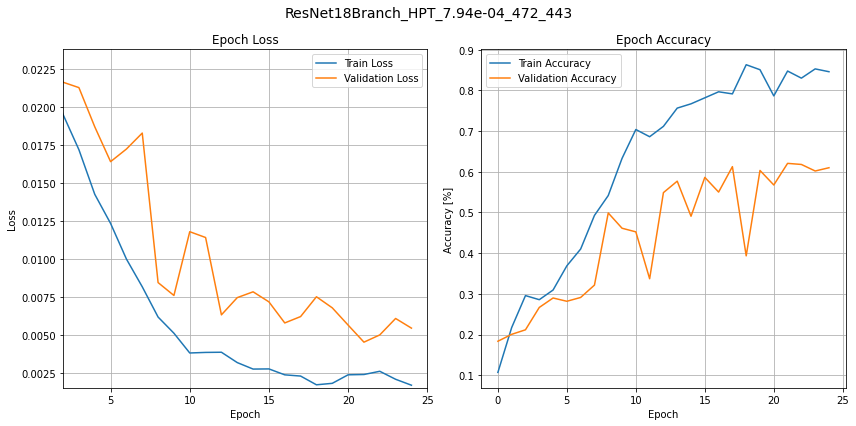



 Entrenamiento modelo: ResNet18Branch_HPT_7.04e-04_2326_315 


Epoch 1/25


Validation loss 0.03654: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.7036 / 12.95% | Validation Loss / Accuracy: 0.0365 / 14.24%
Epoch 2/25


Validation loss 0.03367: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.04e-04_2326_315.pth
[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0291 / 16.30% | Validation Loss / Accuracy: 0.0337 / 19.29%
Epoch 3/25


Validation loss 0.02204: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.04e-04_2326_315.pth
[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0244 / 16.11% | Validation Loss / Accuracy: 0.0220 / 22.28%
Epoch 4/25


Validation loss 0.02414: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0235 / 15.67% | Validation Loss / Accuracy: 0.0241 / 15.80%
Epoch 5/25


Validation loss 0.02153: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.04e-04_2326_315.pth
[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0225 / 18.54% | Validation Loss / Accuracy: 0.0215 / 21.34%
Epoch 6/25


Validation loss 0.02382: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0208 / 20.86% | Validation Loss / Accuracy: 0.0238 / 24.46%
Epoch 7/25


Validation loss 0.01886: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.04e-04_2326_315.pth
[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0195 / 24.14% | Validation Loss / Accuracy: 0.0189 / 26.21%
Epoch 8/25


Validation loss 0.01997: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0159 / 25.75% | Validation Loss / Accuracy: 0.0200 / 20.04%
Epoch 9/25


Validation loss 0.01852: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.04e-04_2326_315.pth
[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0133 / 34.95% | Validation Loss / Accuracy: 0.0185 / 24.78%
Epoch 10/25


Validation loss 0.01677: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.04e-04_2326_315.pth
[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0112 / 36.46% | Validation Loss / Accuracy: 0.0168 / 29.91%
Epoch 11/25


Validation loss 0.01687: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0094 / 42.47% | Validation Loss / Accuracy: 0.0169 / 32.95%
Epoch 12/25


Validation loss 0.01140: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.04e-04_2326_315.pth
[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0074 / 50.60% | Validation Loss / Accuracy: 0.0114 / 38.08%
Epoch 13/25


Validation loss 0.00894: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.04e-04_2326_315.pth
[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0058 / 52.55% | Validation Loss / Accuracy: 0.0089 / 41.96%
Epoch 14/25


Validation loss 0.00910: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0045 / 61.91% | Validation Loss / Accuracy: 0.0091 / 42.14%
Epoch 15/25


Validation loss 0.01086: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0038 / 66.26% | Validation Loss / Accuracy: 0.0109 / 36.52%
Epoch 16/25


Validation loss 0.01115: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0031 / 72.34% | Validation Loss / Accuracy: 0.0112 / 35.76%
Epoch 17/25


Validation loss 0.00772: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.04e-04_2326_315.pth
[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0029 / 73.61% | Validation Loss / Accuracy: 0.0077 / 53.12%
Epoch 18/25


Validation loss 0.00766: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.04e-04_2326_315.pth
[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0024 / 74.94% | Validation Loss / Accuracy: 0.0077 / 50.18%
Epoch 19/25


Validation loss 0.00875: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.81s/it]


[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0022 / 77.68% | Validation Loss / Accuracy: 0.0087 / 44.33%
Epoch 20/25


Validation loss 0.00752: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.04e-04_2326_315.pth
[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0022 / 78.22% | Validation Loss / Accuracy: 0.0075 / 60.04%
Epoch 21/25


Validation loss 0.00817: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0019 / 81.86% | Validation Loss / Accuracy: 0.0082 / 45.40%
Epoch 22/25


Validation loss 0.00600: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.04e-04_2326_315.pth
[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0020 / 82.73% | Validation Loss / Accuracy: 0.0060 / 60.36%
Epoch 23/25


Validation loss 0.00693: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0017 / 82.89% | Validation Loss / Accuracy: 0.0069 / 56.12%
Epoch 24/25


Validation loss 0.00606: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0018 / 84.05% | Validation Loss / Accuracy: 0.0061 / 52.05%
Epoch 25/25


Validation loss 0.00580: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_7.04e-04_2326_315.pth
[Lr:0.0007044462277299037] Training Loss / Accuracy: 0.0017 / 82.40% | Validation Loss / Accuracy: 0.0058 / 56.92%


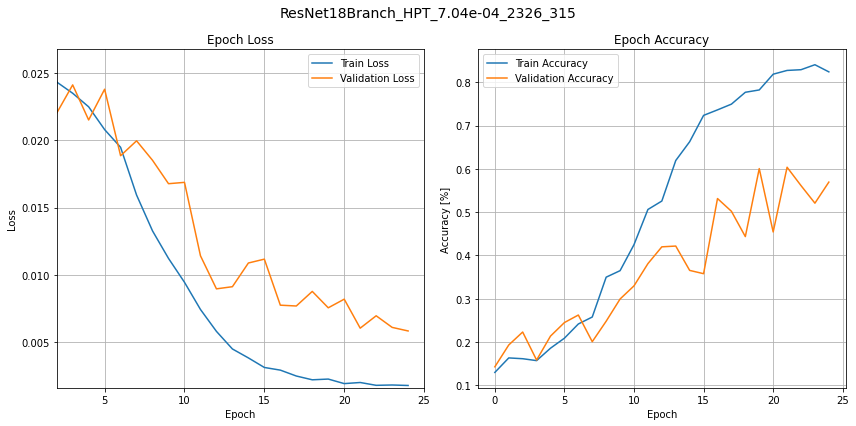



 Entrenamiento modelo: ResNet18Branch_HPT_1.24e-05_1579_683 


Epoch 1/25


Validation loss 0.03131: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0393 / 11.14% | Validation Loss / Accuracy: 0.0313 / 15.49%
Epoch 2/25


Validation loss 0.02372: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.24e-05_1579_683.pth
[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0291 / 16.82% | Validation Loss / Accuracy: 0.0237 / 16.29%
Epoch 3/25


Validation loss 0.02351: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.89s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.24e-05_1579_683.pth
[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0259 / 19.14% | Validation Loss / Accuracy: 0.0235 / 19.29%
Epoch 4/25


Validation loss 0.02303: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.24e-05_1579_683.pth
[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0223 / 17.59% | Validation Loss / Accuracy: 0.0230 / 22.59%
Epoch 5/25


Validation loss 0.02357: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0217 / 21.50% | Validation Loss / Accuracy: 0.0236 / 18.79%
Epoch 6/25


Validation loss 0.02370: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0208 / 23.00% | Validation Loss / Accuracy: 0.0237 / 20.58%
Epoch 7/25


Validation loss 0.02087: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.24e-05_1579_683.pth
[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0197 / 21.07% | Validation Loss / Accuracy: 0.0209 / 19.73%
Epoch 8/25


Validation loss 0.02072: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.24e-05_1579_683.pth
[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0179 / 24.28% | Validation Loss / Accuracy: 0.0207 / 27.01%
Epoch 9/25


Validation loss 0.02105: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0182 / 23.10% | Validation Loss / Accuracy: 0.0211 / 22.59%
Epoch 10/25


Validation loss 0.01927: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.24e-05_1579_683.pth
[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0163 / 27.68% | Validation Loss / Accuracy: 0.0193 / 22.90%
Epoch 11/25


Validation loss 0.01991: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0154 / 27.68% | Validation Loss / Accuracy: 0.0199 / 18.79%
Epoch 12/25


Validation loss 0.02175: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0139 / 31.22% | Validation Loss / Accuracy: 0.0217 / 21.16%
Epoch 13/25


Validation loss 0.01939: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0132 / 36.04% | Validation Loss / Accuracy: 0.0194 / 27.14%
Epoch 14/25


Validation loss 0.01908: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.24e-05_1579_683.pth
[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0123 / 35.61% | Validation Loss / Accuracy: 0.0191 / 24.78%
Epoch 15/25


Validation loss 0.01933: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0121 / 38.15% | Validation Loss / Accuracy: 0.0193 / 29.78%
Epoch 16/25


Validation loss 0.01853: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.24e-05_1579_683.pth
[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0105 / 40.89% | Validation Loss / Accuracy: 0.0185 / 27.81%
Epoch 17/25


Validation loss 0.01765: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.24e-05_1579_683.pth
[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0101 / 41.89% | Validation Loss / Accuracy: 0.0177 / 28.53%
Epoch 18/25


Validation loss 0.01840: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0098 / 41.52% | Validation Loss / Accuracy: 0.0184 / 29.20%
Epoch 19/25


Validation loss 0.01904: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0094 / 43.68% | Validation Loss / Accuracy: 0.0190 / 24.60%
Epoch 20/25


Validation loss 0.01694: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.24e-05_1579_683.pth
[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0088 / 44.91% | Validation Loss / Accuracy: 0.0169 / 29.78%
Epoch 21/25


Validation loss 0.01931: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0080 / 45.17% | Validation Loss / Accuracy: 0.0193 / 33.26%
Epoch 22/25


Validation loss 0.01752: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0077 / 48.01% | Validation Loss / Accuracy: 0.0175 / 28.35%
Epoch 23/25


Validation loss 0.01688: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_1.24e-05_1579_683.pth
[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0071 / 52.40% | Validation Loss / Accuracy: 0.0169 / 28.71%
Epoch 24/25


Validation loss 0.01776: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0071 / 50.29% | Validation Loss / Accuracy: 0.0178 / 25.36%
Epoch 25/25


Validation loss 0.01734: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:1.2419213527017847e-05] Training Loss / Accuracy: 0.0071 / 50.19% | Validation Loss / Accuracy: 0.0173 / 28.84%


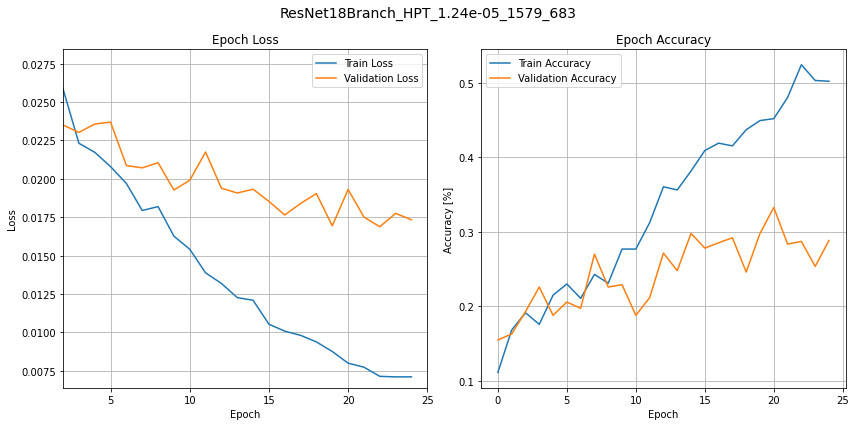



 Entrenamiento modelo: ResNet18Branch_HPT_3.60e-05_1870_866 


Epoch 1/25


Validation loss 0.03115: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0308 / 18.13% | Validation Loss / Accuracy: 0.0311 / 15.31%
Epoch 2/25


Validation loss 0.02590: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_3.60e-05_1870_866.pth
[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0238 / 22.60% | Validation Loss / Accuracy: 0.0259 / 21.47%
Epoch 3/25


Validation loss 0.02219: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_3.60e-05_1870_866.pth
[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0191 / 25.09% | Validation Loss / Accuracy: 0.0222 / 20.49%
Epoch 4/25


Validation loss 0.02252: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0158 / 31.20% | Validation Loss / Accuracy: 0.0225 / 23.35%
Epoch 5/25


Validation loss 0.02177: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_3.60e-05_1870_866.pth
[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0142 / 32.66% | Validation Loss / Accuracy: 0.0218 / 21.65%
Epoch 6/25


Validation loss 0.02032: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_3.60e-05_1870_866.pth
[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0118 / 37.89% | Validation Loss / Accuracy: 0.0203 / 32.14%
Epoch 7/25


Validation loss 0.01818: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_3.60e-05_1870_866.pth
[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0102 / 44.27% | Validation Loss / Accuracy: 0.0182 / 34.38%
Epoch 8/25


Validation loss 0.01605: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_3.60e-05_1870_866.pth
[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0082 / 44.13% | Validation Loss / Accuracy: 0.0161 / 35.58%
Epoch 9/25


Validation loss 0.01841: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0089 / 45.87% | Validation Loss / Accuracy: 0.0184 / 28.84%
Epoch 10/25


Validation loss 0.01862: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0074 / 47.70% | Validation Loss / Accuracy: 0.0186 / 37.95%
Epoch 11/25


Validation loss 0.01996: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0070 / 50.63% | Validation Loss / Accuracy: 0.0200 / 22.86%
Epoch 12/25


Validation loss 0.01652: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0066 / 53.71% | Validation Loss / Accuracy: 0.0165 / 35.76%
Epoch 13/25


Validation loss 0.01567: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_3.60e-05_1870_866.pth
[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0056 / 57.31% | Validation Loss / Accuracy: 0.0157 / 36.83%
Epoch 14/25


Validation loss 0.01581: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0055 / 56.18% | Validation Loss / Accuracy: 0.0158 / 34.15%
Epoch 15/25


Validation loss 0.01487: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_3.60e-05_1870_866.pth
[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0048 / 57.71% | Validation Loss / Accuracy: 0.0149 / 34.15%
Epoch 16/25


Validation loss 0.01243: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_3.60e-05_1870_866.pth
[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0038 / 65.17% | Validation Loss / Accuracy: 0.0124 / 34.20%
Epoch 17/25


Validation loss 0.01368: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0049 / 60.16% | Validation Loss / Accuracy: 0.0137 / 35.58%
Epoch 18/25


Validation loss 0.01328: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0038 / 65.70% | Validation Loss / Accuracy: 0.0133 / 42.37%
Epoch 19/25


Validation loss 0.01453: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0043 / 64.35% | Validation Loss / Accuracy: 0.0145 / 34.46%
Epoch 20/25


Validation loss 0.01325: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0039 / 65.30% | Validation Loss / Accuracy: 0.0132 / 39.20%
Epoch 21/25


Validation loss 0.01308: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:3.602106562357074e-05] Training Loss / Accuracy: 0.0033 / 67.99% | Validation Loss / Accuracy: 0.0131 / 33.08%
Epoch 22/25


Validation loss 0.01358: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Se interrumpió el entrenamiento porque en los últimos 6 epochs no se logró menor loss que el mínimo (min:0.012429319228976965)


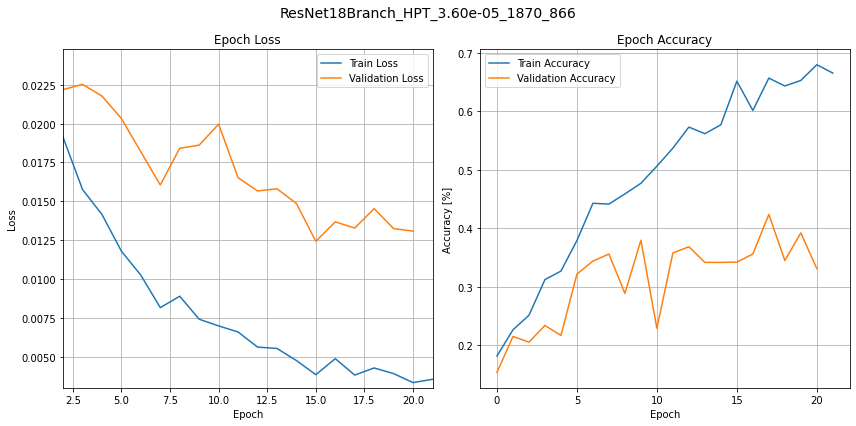



 Entrenamiento modelo: ResNet18Branch_HPT_6.26e-05_2404_394 


Epoch 1/25


Validation loss 0.02904: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0369 / 15.33% | Validation Loss / Accuracy: 0.0290 / 20.85%
Epoch 2/25


Validation loss 0.02188: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_6.26e-05_2404_394.pth
[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0222 / 22.79% | Validation Loss / Accuracy: 0.0219 / 23.53%
Epoch 3/25


Validation loss 0.02387: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0166 / 28.55% | Validation Loss / Accuracy: 0.0239 / 26.21%
Epoch 4/25


Validation loss 0.01891: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_6.26e-05_2404_394.pth
[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0130 / 34.83% | Validation Loss / Accuracy: 0.0189 / 24.24%
Epoch 5/25


Validation loss 0.01979: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0107 / 40.75% | Validation Loss / Accuracy: 0.0198 / 24.91%
Epoch 6/25


Validation loss 0.01562: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_6.26e-05_2404_394.pth
[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0098 / 42.67% | Validation Loss / Accuracy: 0.0156 / 28.39%
Epoch 7/25


Validation loss 0.01627: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0089 / 43.17% | Validation Loss / Accuracy: 0.0163 / 30.58%
Epoch 8/25


Validation loss 0.01687: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0065 / 54.43% | Validation Loss / Accuracy: 0.0169 / 28.79%
Epoch 9/25


Validation loss 0.01604: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0056 / 58.07% | Validation Loss / Accuracy: 0.0160 / 32.32%
Epoch 10/25


Validation loss 0.01587: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0051 / 57.05% | Validation Loss / Accuracy: 0.0159 / 28.35%
Epoch 11/25


Validation loss 0.01474: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_6.26e-05_2404_394.pth
[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0052 / 59.08% | Validation Loss / Accuracy: 0.0147 / 31.16%
Epoch 12/25


Validation loss 0.01435: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_6.26e-05_2404_394.pth
[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0044 / 61.52% | Validation Loss / Accuracy: 0.0144 / 32.14%
Epoch 13/25


Validation loss 0.01461: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0043 / 61.48% | Validation Loss / Accuracy: 0.0146 / 27.72%
Epoch 14/25


Validation loss 0.01375: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_6.26e-05_2404_394.pth
[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0043 / 62.36% | Validation Loss / Accuracy: 0.0138 / 30.58%
Epoch 15/25


Validation loss 0.01412: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0042 / 63.21% | Validation Loss / Accuracy: 0.0141 / 33.88%
Epoch 16/25


Validation loss 0.01459: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0034 / 68.58% | Validation Loss / Accuracy: 0.0146 / 28.93%
Epoch 17/25


Validation loss 0.01518: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0030 / 70.17% | Validation Loss / Accuracy: 0.0152 / 33.13%
Epoch 18/25


Validation loss 0.01287: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_6.26e-05_2404_394.pth
[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0034 / 70.70% | Validation Loss / Accuracy: 0.0129 / 36.70%
Epoch 19/25


Validation loss 0.01200: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_6.26e-05_2404_394.pth
[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0027 / 74.71% | Validation Loss / Accuracy: 0.0120 / 33.88%
Epoch 20/25


Validation loss 0.01267: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0031 / 71.87% | Validation Loss / Accuracy: 0.0127 / 35.45%
Epoch 21/25


Validation loss 0.01272: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0034 / 68.72% | Validation Loss / Accuracy: 0.0127 / 29.42%
Epoch 22/25


Validation loss 0.01215: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0030 / 71.38% | Validation Loss / Accuracy: 0.0122 / 41.56%
Epoch 23/25


Validation loss 0.01158: 100%|███████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_6.26e-05_2404_394.pth
[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0036 / 68.63% | Validation Loss / Accuracy: 0.0116 / 34.38%
Epoch 24/25


Validation loss 0.01179: 100%|███████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.03s/it]


[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0030 / 70.84% | Validation Loss / Accuracy: 0.0118 / 35.58%
Epoch 25/25


Validation loss 0.01112: 100%|███████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.44s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/ResNet18Branch_HPT_6.26e-05_2404_394.pth
[Lr:6.263207452198692e-05] Training Loss / Accuracy: 0.0028 / 74.16% | Validation Loss / Accuracy: 0.0111 / 36.65%


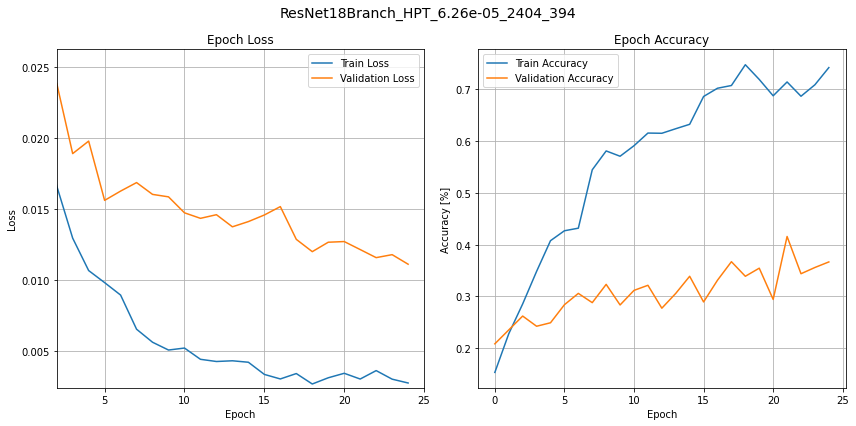

In [ ]:

for hyperparam in hyperparams:
    
    name = f"MobileNetV2_HPT__lr_{hyperparam['lr']:.2e}__lastfc_{hyperparam['n_last_fc']}__branchfc_{hyperparam['n_brach_fc']}"
    
    modelHPTuning = GazeEstimation_ResNet18Branch(name=name, trainable=True, n_last_fc=hyperparam['n_last_fc'], n_brach_fc=hyperparam['n_brach_fc'])

    # Seteamos un early stop
    modelHPTuning.early_stop = True
    modelHPTuning.not_minimum_count = 5

    # Al ser un problema de regresión se usa MSELoss
    criterion = nn.MSELoss()

    # Optimizador: Adam
    optimizer = torch.optim.Adam(modelHPTuning.parameters(), lr=hyperparam['lr'])

    # Entrenamiento
    print(f"\n\n Entrenamiento modelo: {name} \n\n")
    modelHPTuning.fit(train_loader, val_loader, criterion, optimizer, epochs=25, device=device, save_model=True)

    plot_metrics(modelHPTuning, title=name)
    